# Introduction

As this is a mutli-label problem, there are 2 different steps taken to further explore on which modeling method is the best for this problem. 

The first method used is to split the features up individually, and then constructing a model for each feature. This is done to see if the model can predict the features individually.

This notebook details the steps taken to split the features up individually, and then constructing a model for each feature. This is done to see if the model can predict the features individually.

In [13]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette('muted')
plt.style.use('tableau-colorblind10')

from itertools import cycle
import pickle
import scipy
import json
import os
import datetime

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem import WordNetLemmatizer


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss, confusion_matrix, average_precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.metrics import Precision, Recall, Accuracy, PrecisionAtRecall, AUC

In [6]:
# Read in the pickle file

with open('../pickled_models/after_eda.pickle', 'rb') as f:
    df_train = pickle.load(f)

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,word_count,unique_word_count,upper_case_word_count,stop_word_count,punctuation_count,title_word_count,sentence_count,percent_unique_word_count,percent_upper_case_word_count,percent_punctuation_count,cleaned_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,41,2,20,10,11,5,95.348837,4.651163,23.255814,explanation why the edit make under username h...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,17,1,3,12,3,4,100.000000,5.882353,70.588235,aww match this background colour seemingly sti...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,39,0,21,6,2,4,92.857143,0.000000,14.285714,hey man really not try edit war just that this...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,82,5,58,21,7,6,72.566372,4.424779,18.584071,more cannot make any real suggestions improvem...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,13,0,6,5,2,3,100.000000,0.000000,38.461538,you sir hero any chance you remember what page...


Tfidf Vectorizer has been chosen for the modeling

TF is the term frequency which works by looking at the frequency of the word in the document. This is similar to countvectorizer.
The second part IDF is the inverse document frequency which works by looking at the frequency of the word in the entire corpus. This is to reduce the weight of the word if it is too common in the corpus.If the word is too common, the IDF helps to minimize the weight of the word by taking the inverse.

This also helps to normalize the data.

## Function for modeling

In [201]:
def gs(feature, pipe, pipe_params, filename, metric):

    """
    Function created to split the data into X and y, and then split the data into train and test sets.
    A gridsearch will then be conducted, and saving the best models according to the chosen metric in a pickle file.
    """

    X = df_train["cleaned_comment_text"]
    y = df_train[feature]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, scoring=metric, n_jobs=-1)

    gs.fit(X_train, y_train)

    with open(f"../pickled_models/{metric}/{filename}.pickle", "wb") as f:
        pickle.dump(gs, f)

In [202]:
# Pipeline creation
tfidf_log_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('lg', LogisticRegression())
])

tfidf_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('svc', LinearSVC())
])

tfidf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('nb', ComplementNB())
])

In [203]:
# params creation
tfidf_log_params = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'lg__solver': ['liblinear'],
    'lg__C': [0.01, 0.1, 1, 10, 100],
    'lg__penalty': ['l1', 'l2'],
    'lg__max_iter': [1000,2000],
    'lg__class_weight': ['balanced']
}

tfidf_svc_params = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svc__C': [0.01,0.1 ,1, 10, 100],
    'svc__max_iter': [10_000],
    'svc__class_weight': ['balanced']
}

tfidf_nb_params = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.01, 0.1, 1, 10, 100]
}

# Modeling

In [204]:
# Putting the models into a dictionary

log_models = {
    'toxic': 'toxic_tfidf_log',
    'severe_toxic' : 'severe_toxic_tfidf_log',
    'obscene' : 'obscene_tfidf_log',
    'threat' : 'threat_tfidf_log',
    'insult' : 'insult_tfidf_log',
    'identity_hate' : 'identity_hate_tfidf_log'
}

nb_models = {
    'toxic': 'toxic_tfidf_nb',
    'severe_toxic' : 'severe_toxic_tfidf_nb',
    'obscene' : 'obscene_tfidf_nb',
    'threat' : 'threat_tfidf_nb',
    'insult' : 'insult_tfidf_nb',
    'identity_hate' : 'identity_hate_tfidf_nb'
}

svc_models = {
    'toxic': 'toxic_tfidf_svc',
    'severe_toxic' : 'severe_toxic_tfidf_svc',
    'obscene' : 'obscene_tfidf_svc',
    'threat' : 'threat_tfidf_svc',
    'insult' : 'insult_tfidf_svc',
    'identity_hate' : 'identity_hate_tfidf_svc'
}

## Gridsearch with accuracy metrics

In [17]:
# Loop through the models and run the gridsearch
for k,v in svc_models.items():
    gs(feature=k, pipe=tfidf_svc_pipe, pipe_params=tfidf_svc_params, filename=v, metric='accuracy')

# Do not run - takes a long time

KeyboardInterrupt: 

In [ ]:
for k,v in log_models.items():
    gs(feature=k, pipe=tfidf_log_pipe, pipe_params=tfidf_log_params, filename=v, metric='accuracy')

# Do not run - takes a long time

In [ ]:
for k,v in nb_models.items():
    gs(feature=k, pipe=tfidf_nb_pipe, pipe_params=tfidf_nb_params, filename=v, metric='accuracy')

# Do not run - takes a long time

The above gridsearch function was used with the metrics accuracy to find the best model. However, after careful consideration, average_precision is more suitable for this problem, as we want to find the model with the best precision (least false negative).

## Gridsearch with Average Precision

As the dataset is imbalanced, and we want to predict the minority class. Normally we would use the F1 score as the metric. However, we want to see how the model performs on the 

In [ ]:
for k,v in log_models.items():
    gs(feature=k, pipe=tfidf_log_pipe, pipe_params=tfidf_log_params, filename=v, metric='average_precision')

/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
for k,v in nb_models.items():
    gs(feature=k, pipe=tfidf_nb_pipe, pipe_params=tfidf_nb_params, filename=v, metric='average_precision')

In [ ]:
for k,v in svc_models.items():
    gs(feature=k, pipe=tfidf_svc_pipe, pipe_params=tfidf_svc_params, filename=v, metric='average_precision')

/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to 

# Evaluation

In [18]:
# evaulation

# Function to plot confusion matrix and obtain the metrics into a dataframe

def results_extraction(feature="", model_name="", results={}, folder_name="", metric=""):

    '''
    Function to extract the pickle-ed model and to conduct predictions with X_test, saving the final results to a separate dataframe
    '''

    X = df_train["cleaned_comment_text"]
    y = df_train[feature]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Extract the model
    filename = f'../pickled_models/{metric}/{model_name}.pickle'
    with open(filename, 'rb') as f:
        model = pickle.load(f)

        y_pred = model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[f'non-{feature}', feature]).plot(cmap='Blues')

    plt.title(f'{model_name}: Confusion Matrix')
    plt.savefig(f"../confusion_matrix/{folder_name}/{metric}/{model_name}_{metric}_confusion_matrix.png", bbox_inches='tight', facecolor='w')
    plt.close()

    # Different metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    misclassification = 1 - accuracy
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * recall) / (precision + recall)

    acc_diff = np.abs((model.score(X_train, y_train) - model.score(X_test, y_test))) / model.score(X_train, y_train)

    # Metrics for roc curve and auc
    # LinearSVC does not have predict proba - decision function will be used instead
    if "svc" not in model_name:
        pred_proba = model.predict_proba(X_test)[:,1]
        train_proba = model.predict_proba(X_train)[:,1]


    else:
        pred_proba = model.decision_function(X_test)
        train_proba = model.decision_function(X_train)

    pred_auc_score = roc_auc_score(y_test, pred_proba)
    train_auc_score = roc_auc_score(y_train, train_proba)
    pred_prc_score = average_precision_score(y_test, pred_proba)
    train_prc_score = average_precision_score(y_train, train_proba)
    auc_diff = np.abs((train_auc_score - pred_auc_score)) / train_auc_score
    prc_diff = np.abs((train_prc_score - pred_prc_score)) / train_prc_score


    # Append all above results to 'results' dictionary
    results[model_name] = [
        metric,
        model.best_params_,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        misclassification,
        recall,
        specificity,
        precision,
        f1,
        train_auc_score,
        pred_auc_score,
        train_prc_score,
        pred_prc_score,
        auc_diff,
        prc_diff,
        acc_diff
    ]

In [17]:
# Create a dataframe to combine all results

def all_data(results_list=[], results_dict={}):
    '''
    Function to create a dataframe for all results
    '''
    for r in results_list:
            # pd.DataFrame()
        for k,v in r.items():
            results_dict[k] = v
        
    df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['metric','best_params', 'train_acc_score', 'test_acc_score', 'misclassification', 'recall', 'specificity', 'precision', 'f1', 'train_auc', 'pred_auc', 'train_prc', 'pred_prc', 'auc_diff', 'prc_diff', 'acc_diff'])
    
    return df

In [14]:
# Extraction of results for accuracy metric models
results_log_acc = {}
for k,v in log_models.items():
    results_extraction(feature=k, model_name=v, results=results_log_acc, folder_name="logistic_regression", metric='accuracy')

results_nb_acc = {}
for k,v in nb_models.items():
    results_extraction(feature=k, model_name=v, results=results_nb_acc, folder_name="naive_bayes", metric='accuracy')

results_svc_acc = {}
for k,v in svc_models.items():
    results_extraction(feature=k, model_name=v, results=results_svc_acc, folder_name="linear_svc", metric='accuracy')

In [15]:
# Extraction of results for average_precision metric models
results_log_prc = {}
for k,v in log_models.items():
    results_extraction(feature=k, model_name=v, results=results_log_prc, folder_name="logistic_regression", metric='average_precision')

results_nb_prc = {}
for k,v in nb_models.items():
    results_extraction(feature=k, model_name=v, results=results_nb_prc, folder_name="naive_bayes", metric='average_precision')

results_svc_prc = {}
for k,v in svc_models.items():
    results_extraction(feature=k, model_name=v, results=results_svc_prc, folder_name="linear_svc", metric='average_precision')

In [18]:
# Combination of all results with the help of the predefined function
results_list_acc = [
    results_log_acc,
    results_nb_acc,
    results_svc_acc,
]

results_list_prc = [
    results_log_prc,
    results_nb_prc,
    results_svc_prc,
]

acc_final_results = all_data(results_list=results_list_acc, results_dict={})
prc_final_results = all_data(results_list=results_list_prc, results_dict={})

final_results = pd.concat([acc_final_results.reset_index(), prc_final_results.reset_index()], axis=0, ignore_index=True)
final_results.head()

In [22]:
# Saving the final results into a pickle file
with open('../pickled_models/final_split_results.pickle', 'wb') as f:
    pickle.dump(final_results, f)

In [28]:
with open("../pickled_models/final_split_results.pickle", "rb") as f:
    final_results = pickle.load(f)

# Confusion Matrix

In [256]:
def cm(model_dict, metric="", model_type=""):
    """
    Function defined to plot the confusion matrix for each models showing all the features in 1 plot
    """
    f, axes = plt.subplots(2, 3, figsize=(25, 15))
    axes = axes.ravel()

    plt.suptitle(f"Confusion Matrices for {model_type} - {metric} metric".title(), fontsize=20)
    for c, (k,v) in enumerate(model_dict.items()):
        X = df_train["cleaned_comment_text"]
        y = df_train[k]

        # train test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Extract the model
        filename = f'../pickled_models/{metric}/{v}.pickle'
        with open(filename, 'rb') as f:
            model = pickle.load(f)

            y_pred = model.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[f'non-{k}', k]).plot(ax=axes[c])
        disp.ax_.set_title(f"{k} - {metric} metric".title(), fontsize=15)
        disp.im_.colorbar.remove()

        plt.savefig(f"../confusion_matrix/{model_type}/{metric}/overall_confusion_matrix_{model_type}_{metric}.png", bbox_inches='tight')

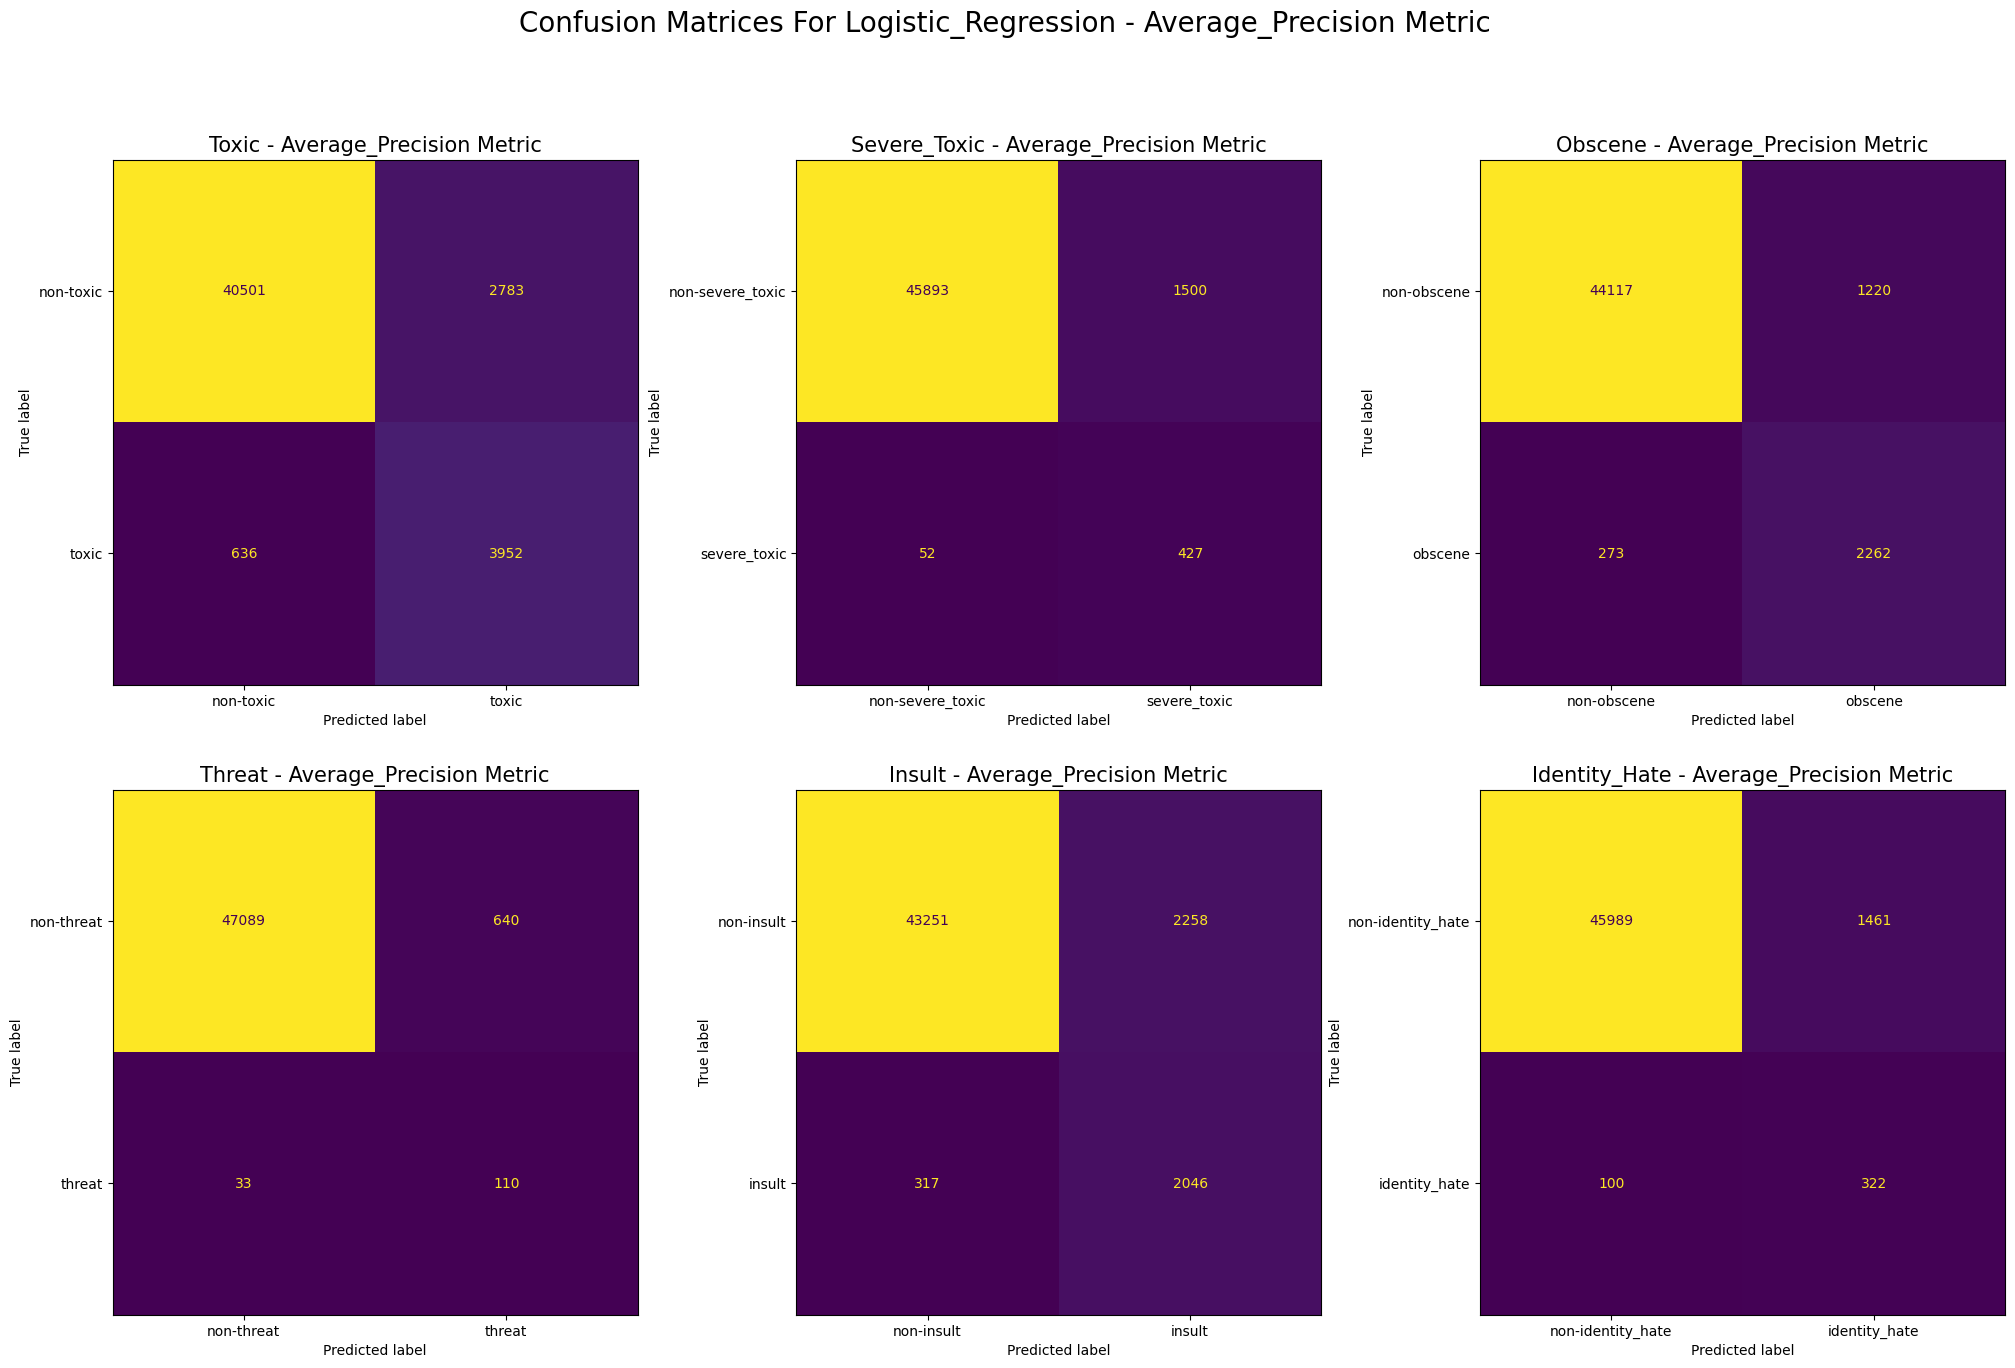

In [257]:
cm(model_dict=log_models, metric="average_precision", model_type="logistic_regression")


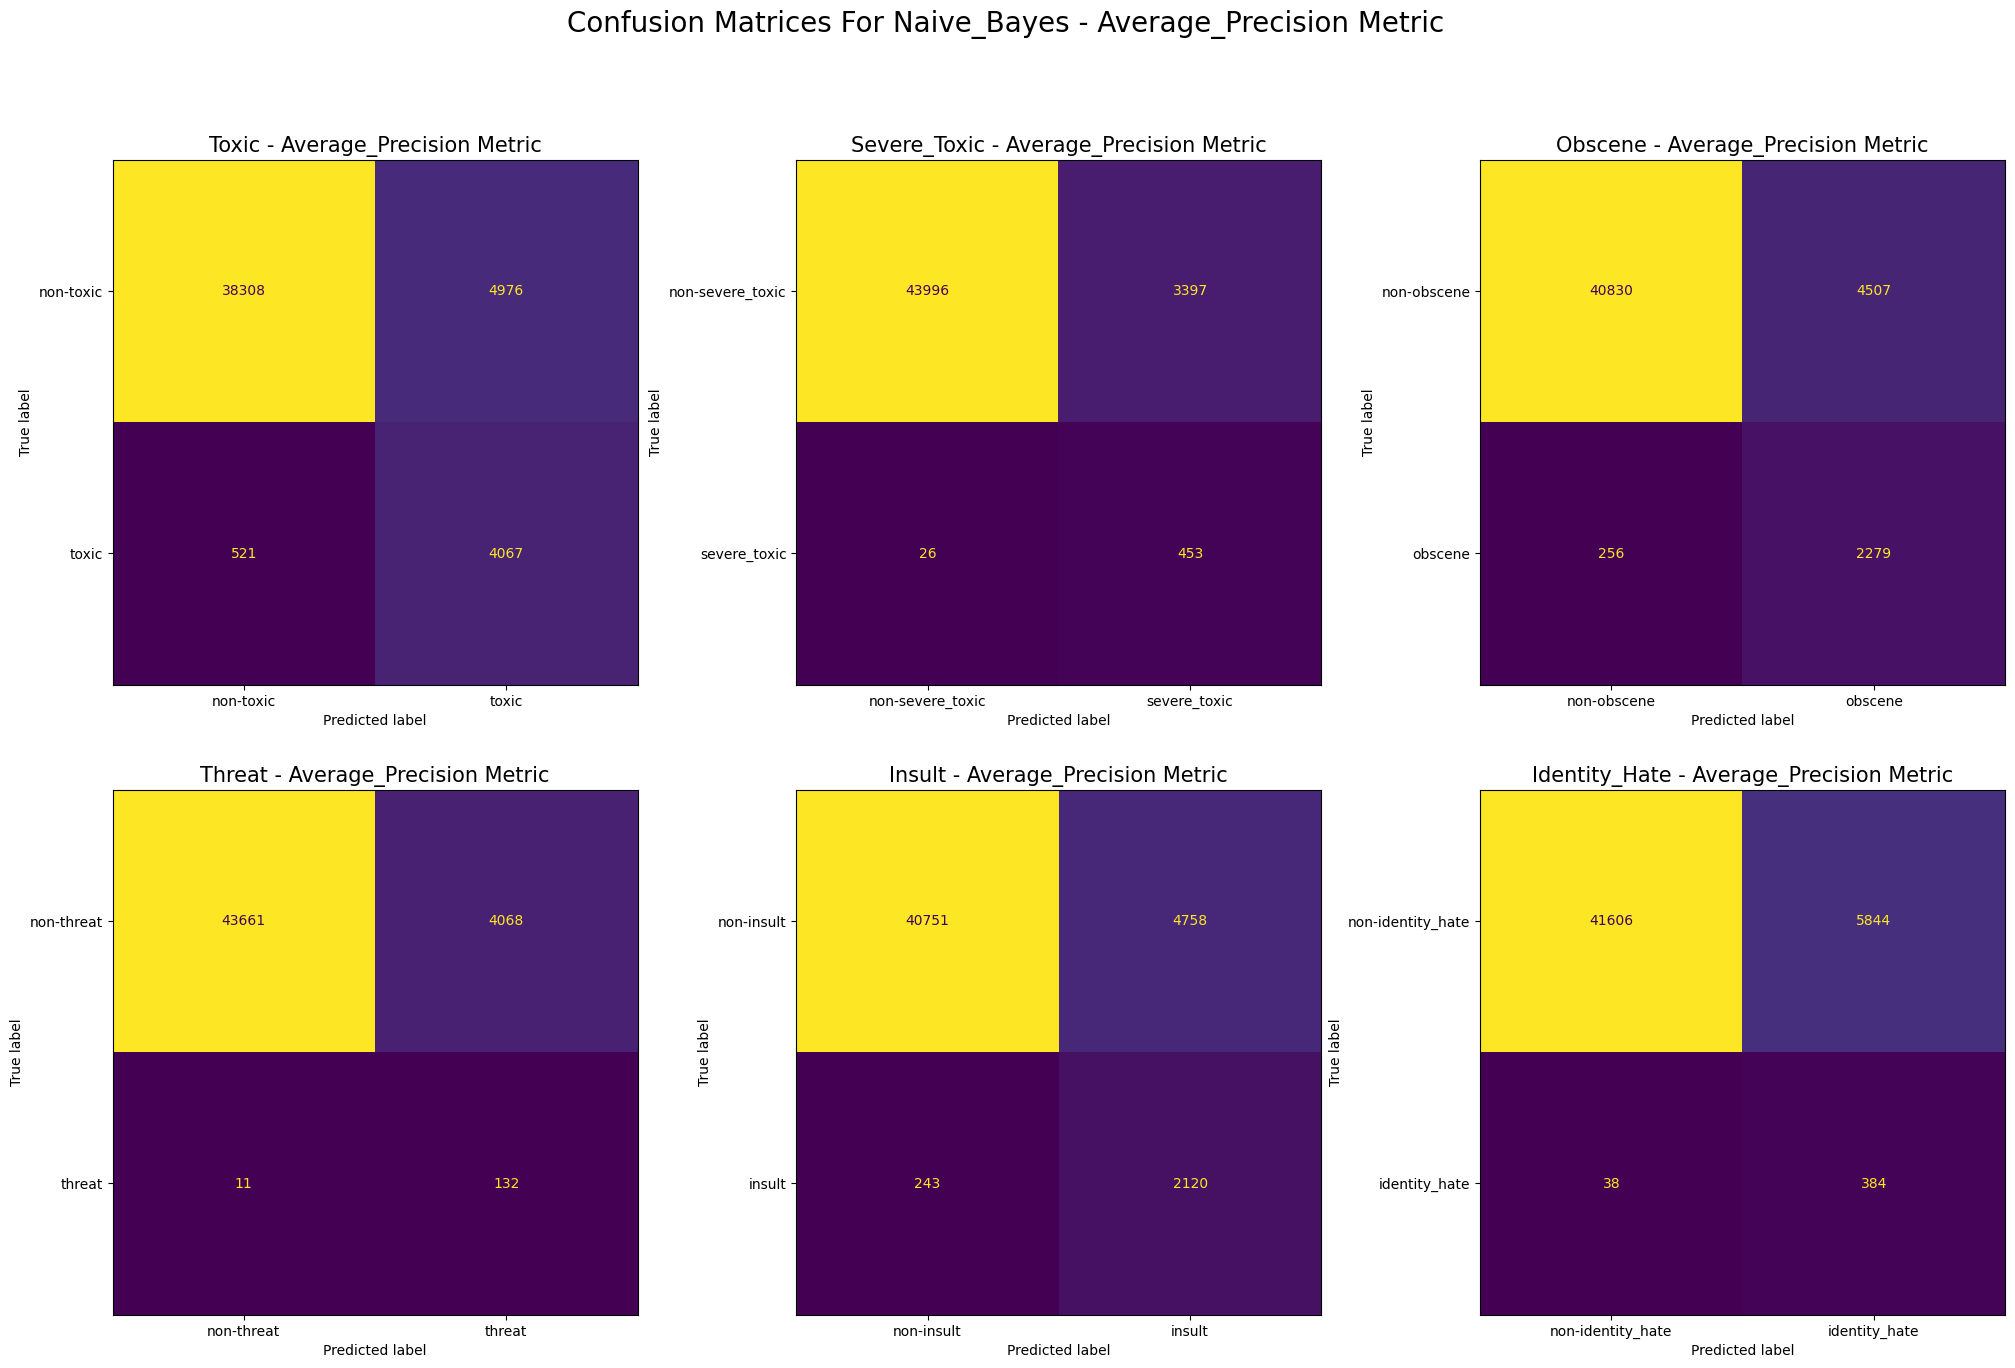

In [258]:
cm(model_dict=nb_models, metric="average_precision", model_type="naive_bayes")

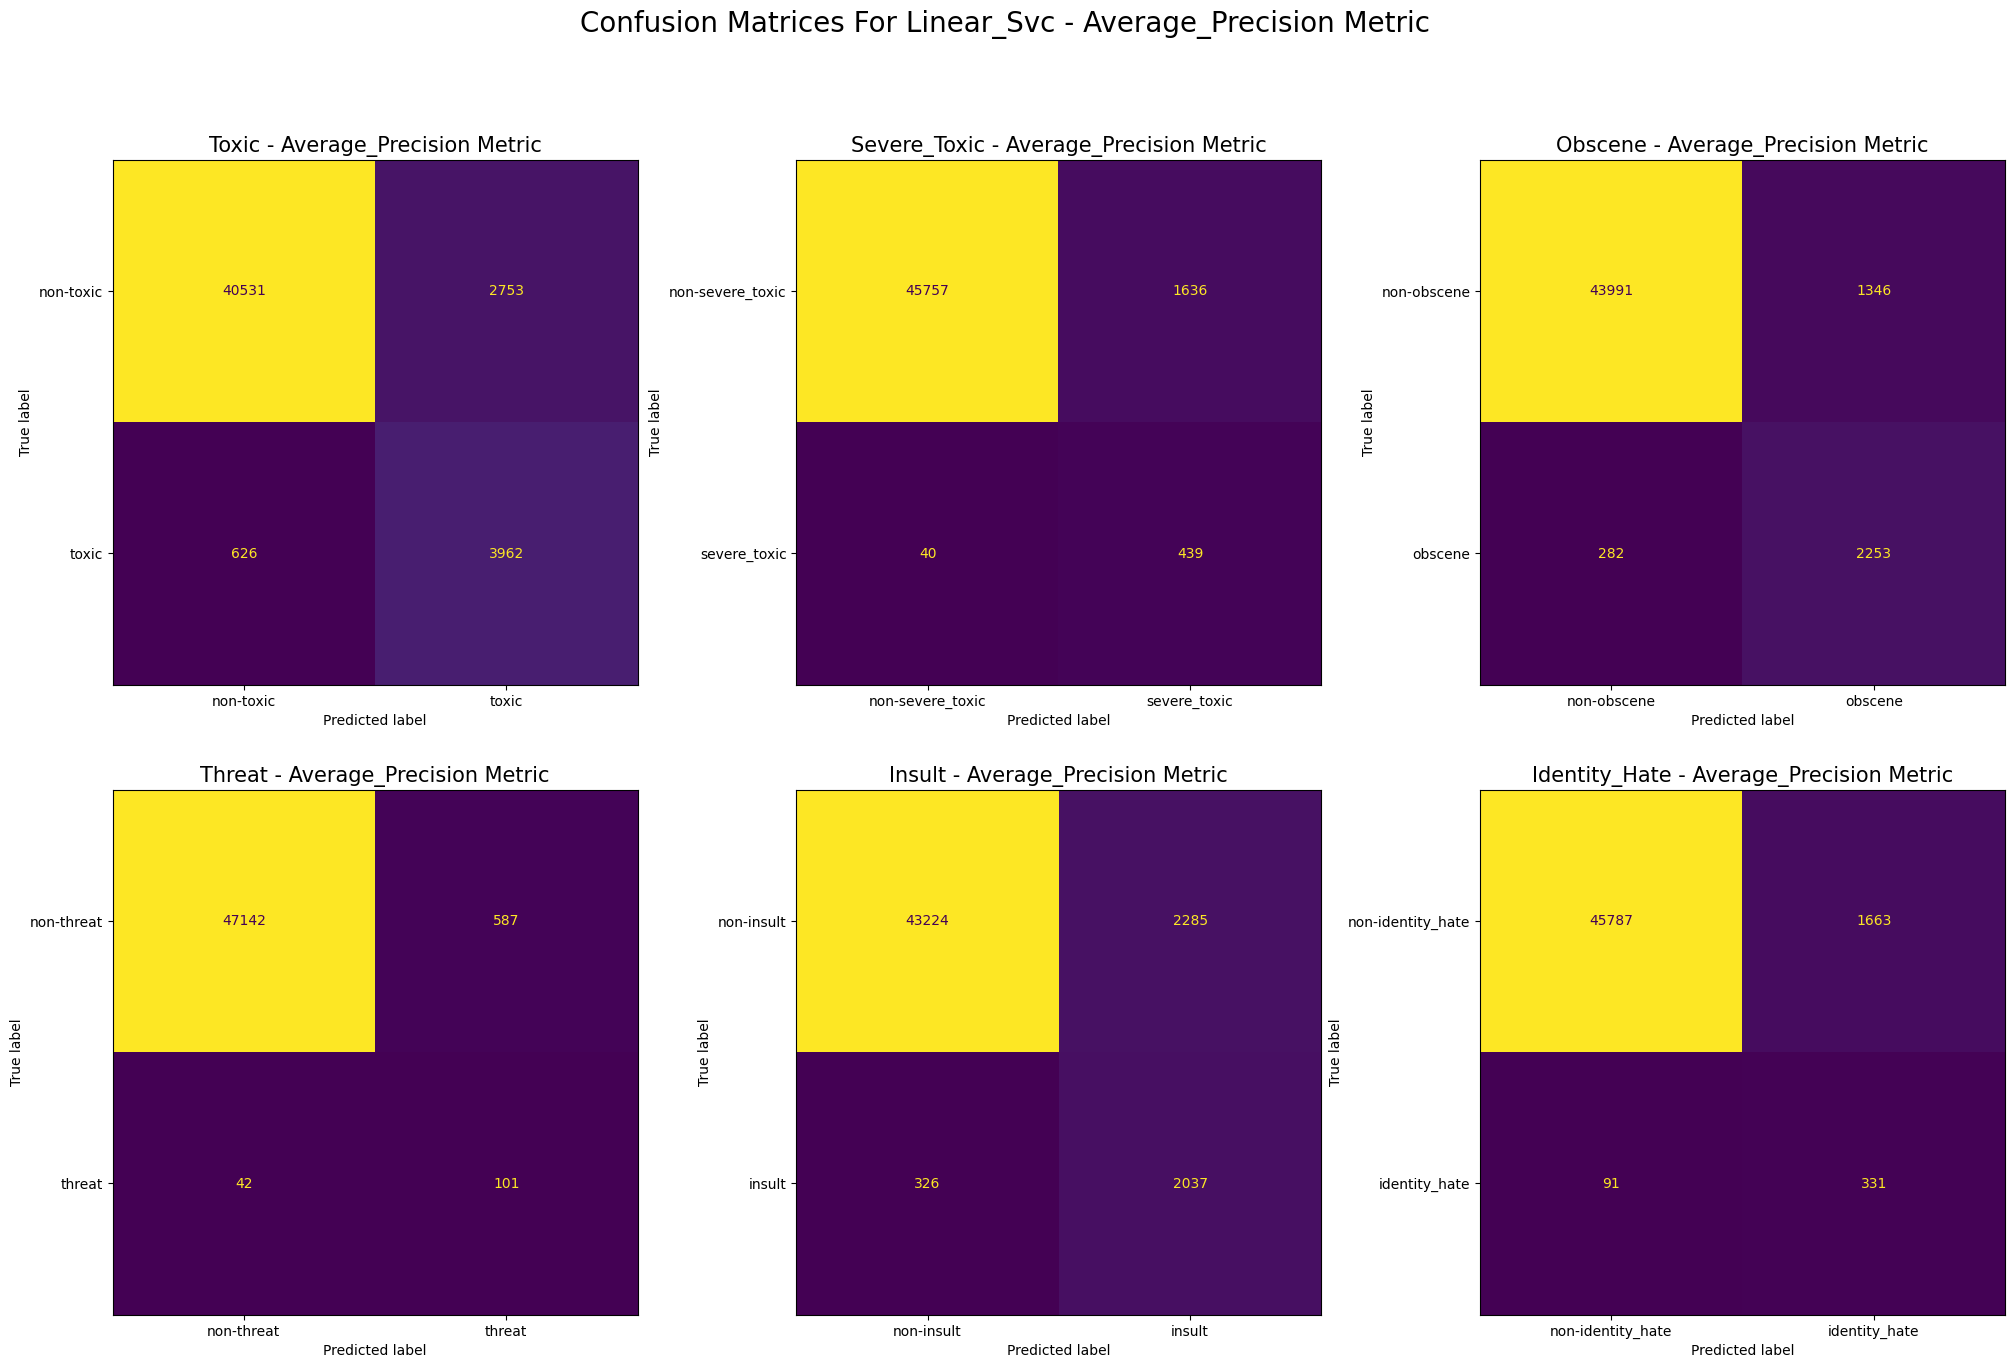

In [259]:
cm(model_dict=svc_models, metric="average_precision", model_type="linear_svc")

# Precision Recall Curve

In [19]:
# Function to plot the prc and auc curves


def plot_prc(models_list, metrics, model_type):
    '''
    Function to plot the prc curves for all features
    '''
    # setup plot details
    colors = cycle(sns.color_palette("Set2", 10))

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    for k, v in models_list.items():
        X = df_train["cleaned_comment_text"]
        y = df_train[k]

        # train test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        filename = f"../pickled_models/{metrics}/{k}_tfidf_{model_type}.pickle"
        with open(filename, "rb") as f:
            model = pickle.load(f)
        display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=k)
        plt.close()
        display.plot(ax=ax, color=next(colors), name=k)


    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    ax.set_title(f"{metrics} - Precision-Recall curve - {model_type}".title())
    plt.savefig(f"../charts/model_plots/{metrics}_prc_{model_type}.png", bbox_inches="tight")

    plt.show()

In [20]:

def plot_roc(models_list, metrics, model_type):
    '''
    Function to plot roc curve for all features
    '''
    # setup plot details
    colors = cycle(sns.color_palette("Set2", 10))

    _, ax = plt.subplots(figsize=(7, 8))

    for k, v in models_list.items():
        X = df_train["cleaned_comment_text"]
        y = df_train[k]

        # train test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        filename = f"../pickled_models/{metrics}/{k}_tfidf_{model_type}.pickle"
        with open(filename, "rb") as f:
            model = pickle.load(f)
        display = RocCurveDisplay.from_estimator(model, X_test, y_test, name=k)
        plt.close()
        display.plot(ax=ax, color=next(colors), name=k)


    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    ax.set_title(f"{metrics} - ROC curve - {model_type}".title())
    plt.savefig(f"../charts/model_plots/{metrics}_roc_{model_type}.png", bbox_inches="tight")

    plt.show()

## Accuracy Metric Plots

In [207]:
dict_models = {
    'log_models' : 'log',
    'nb_models' : 'nb',
    'svc_models' : 'svc'
}

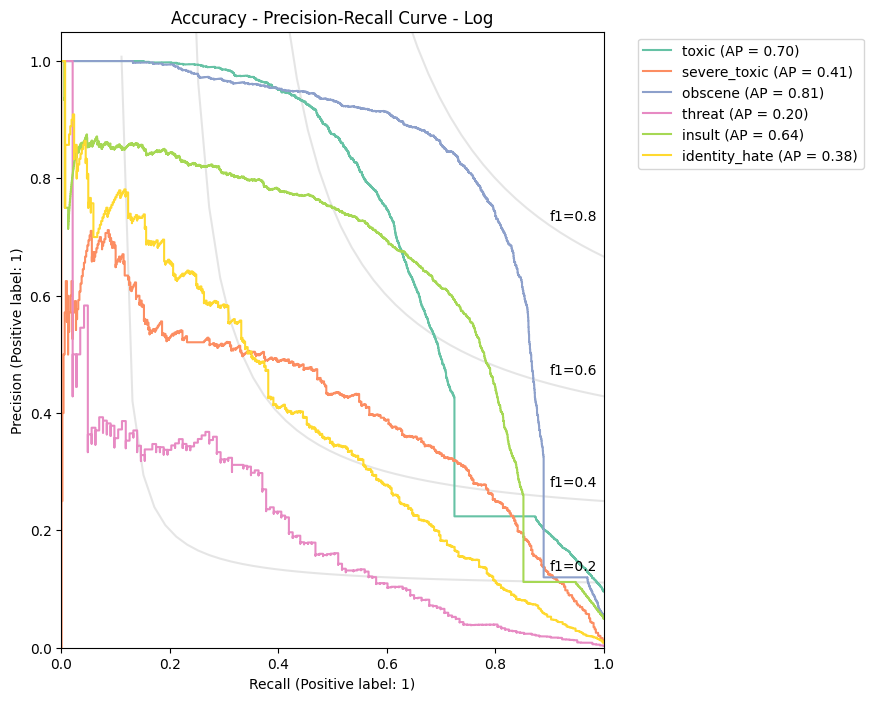

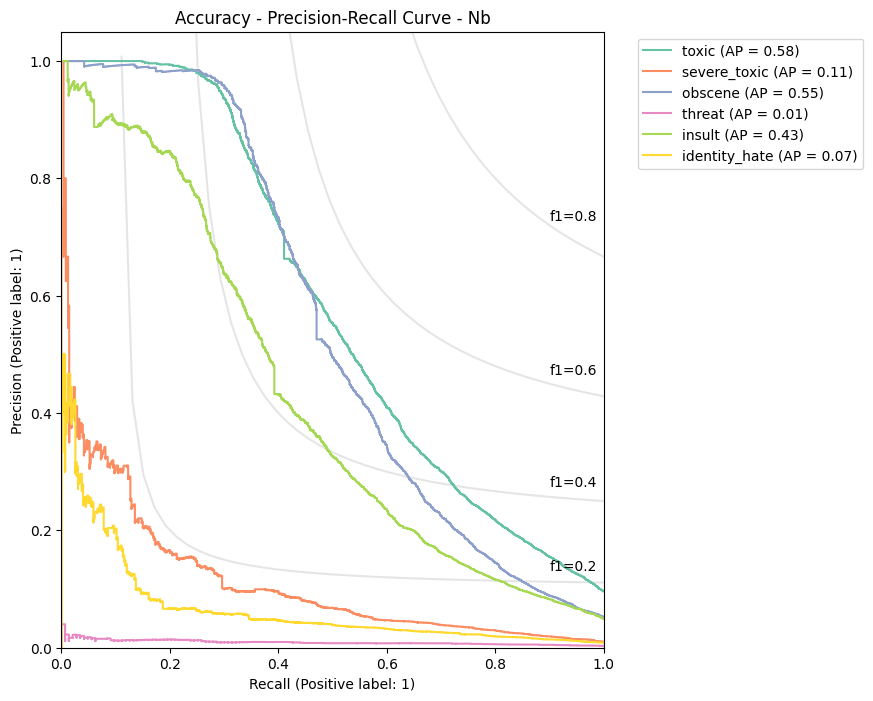

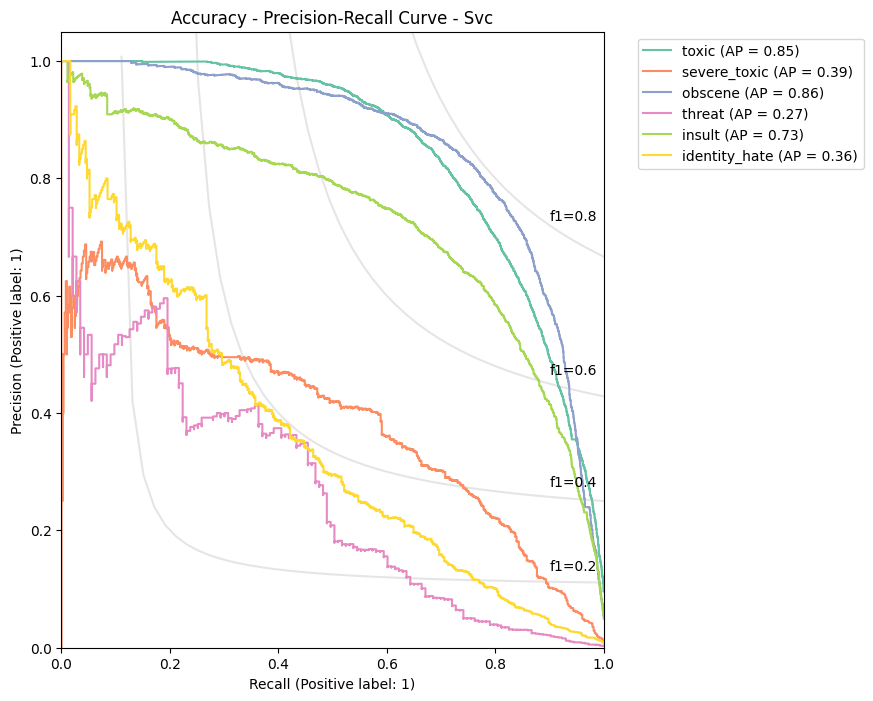

In [22]:
# Prc curve - for models that are tuned to maximize accuracy
for k,v in dict_models.items():
    plot_prc(models_list=eval(k), metrics='accuracy', model_type=v)

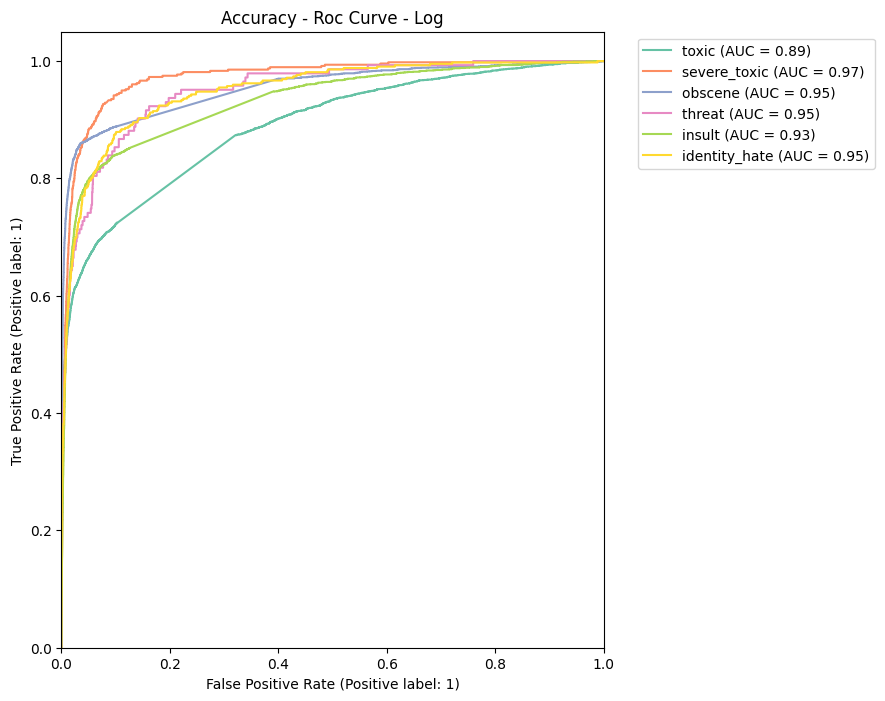

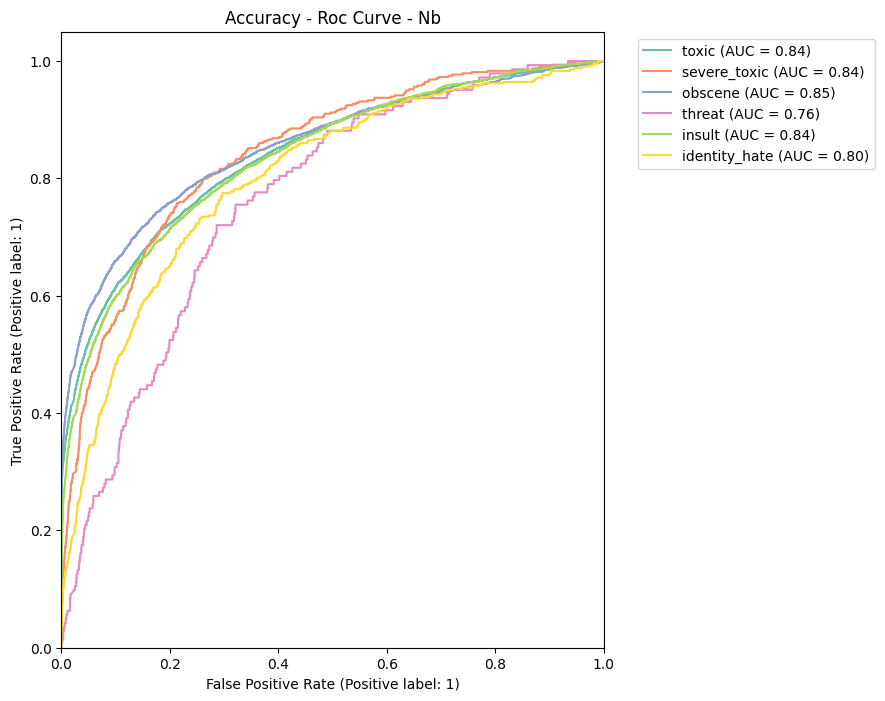

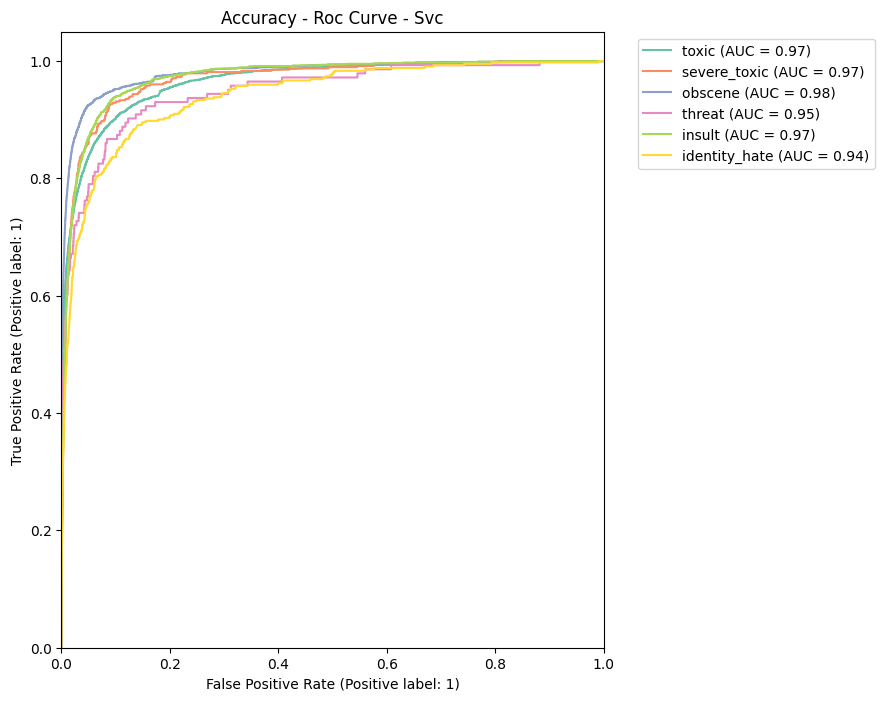

In [ ]:
# Roc curve - for models that are tuned to maximize accuracy
for k,v in dict_models.items():
    plot_roc(models_list=eval(k), metrics='accuracy', model_type=v)

## Average Precision Plots

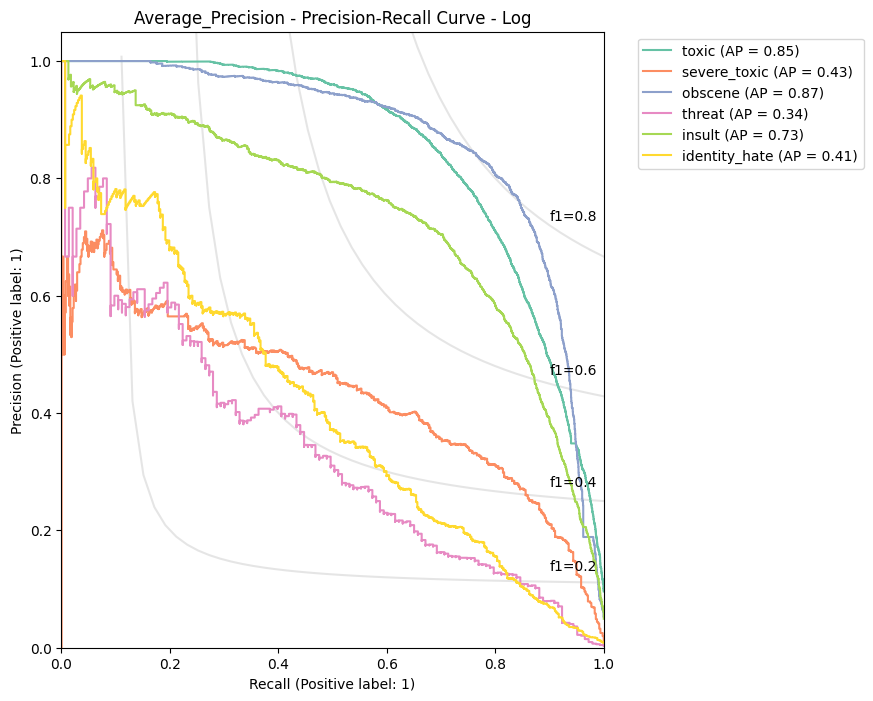

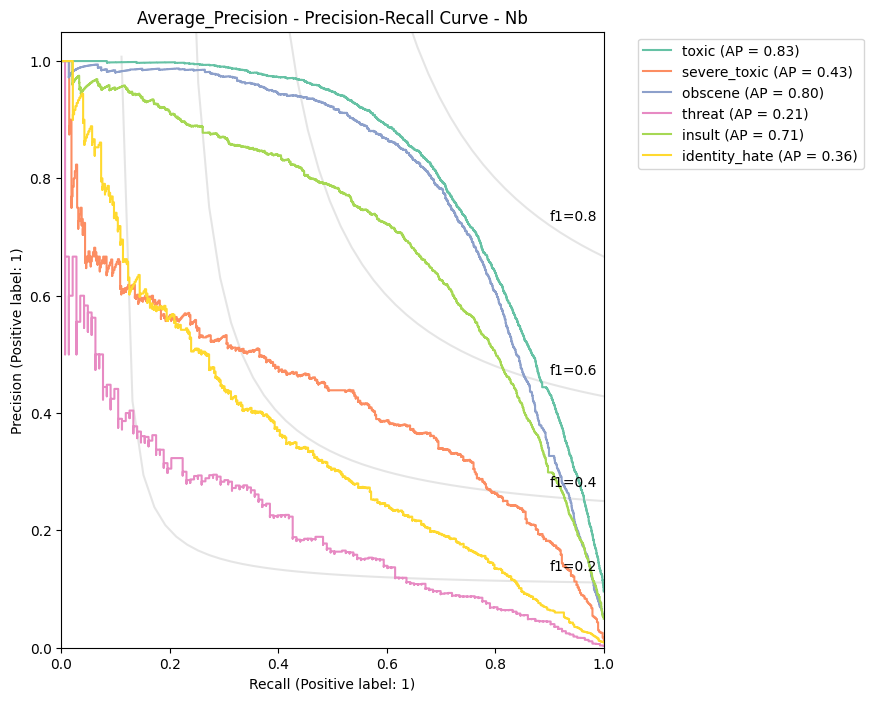

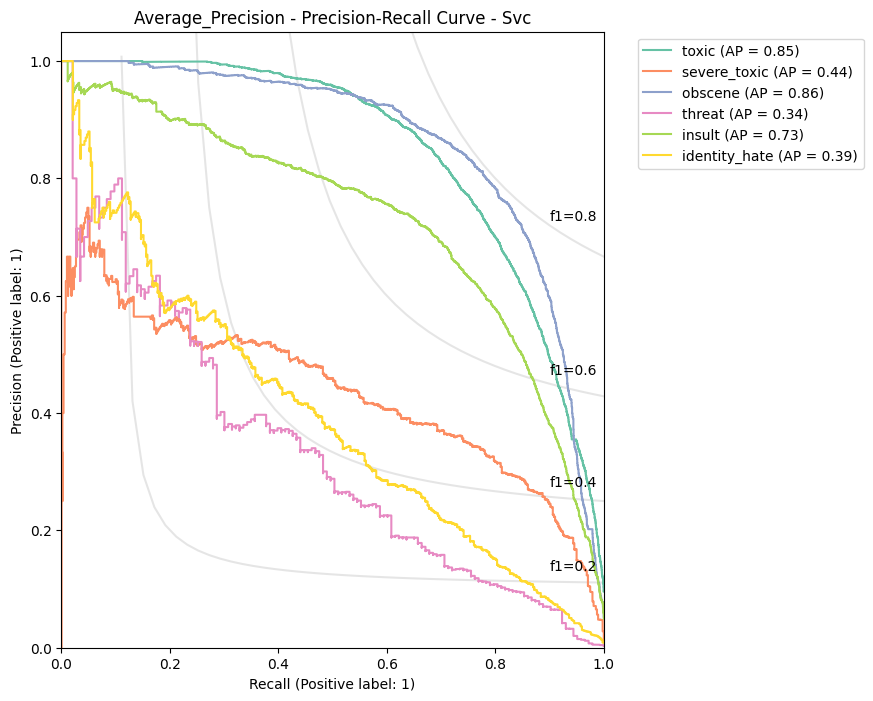

In [23]:
# Prc curve - for models that are tuned to maximize average_precision
for k,v in dict_models.items():
    plot_prc(models_list=eval(k), metrics='average_precision', model_type=v)

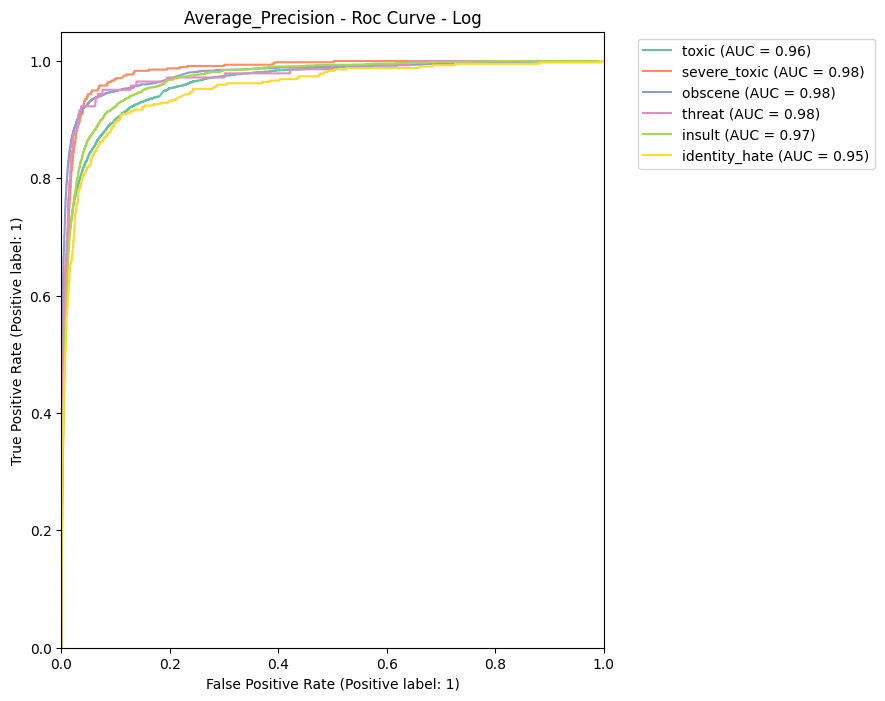

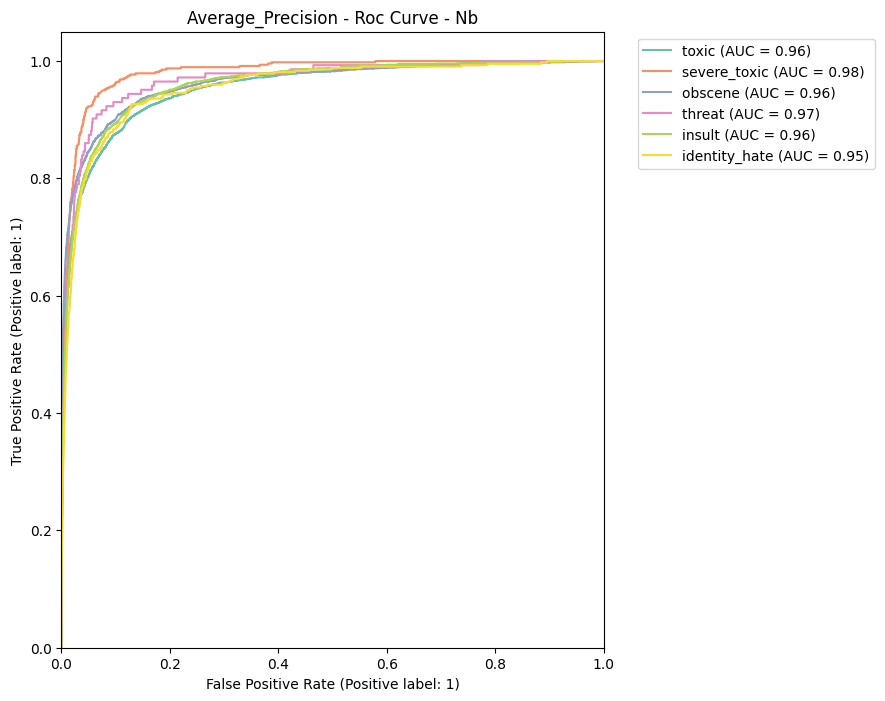

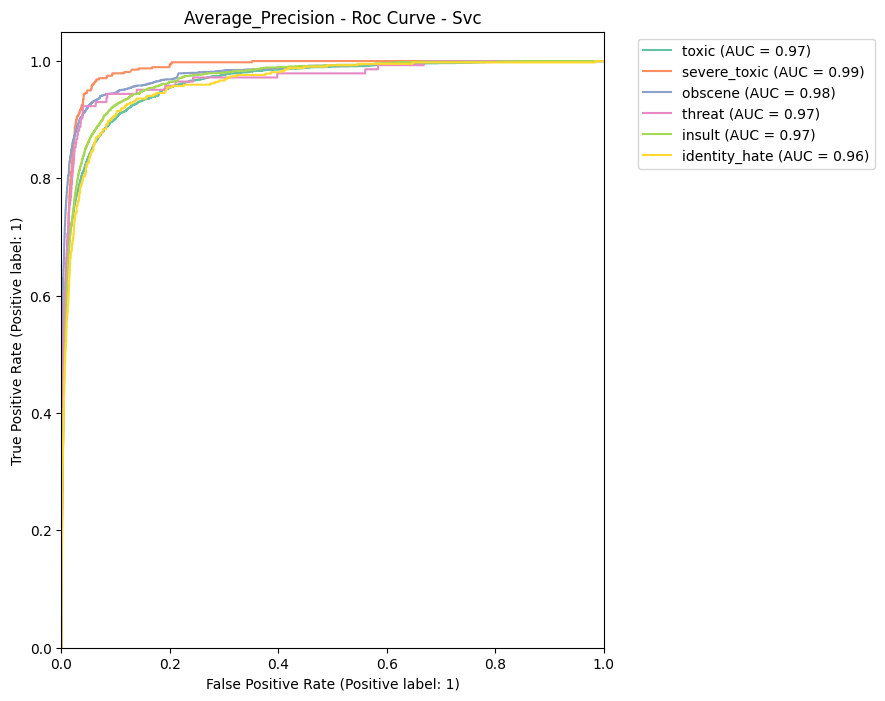

In [26]:
# Roc curve - for models that are tuned to maximize average_precision
for k,v in dict_models.items():
    plot_roc(models_list=eval(k), metrics='average_precision', model_type=v)

# Neural Network

Looking into neural network, the model would be able to predict this multi-label problem. As the nerual network is able to predict 6 different features at the same time.

In [7]:
# train test split

features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

X = df_train["cleaned_comment_text"].to_numpy()
y = df_train[features].to_numpy()

# Due to sklearn's train-test-split not supporting multi-label classification, we will use the iterative stratification package
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=42)

for train_index, test_index in msss.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

TRAIN: [     0      1      3 ... 159567 159568 159570] TEST: [     2      5      8 ... 159556 159562 159569]
TRAIN: [     0      1      2 ... 159567 159569 159570] TEST: [     3      4     10 ... 159559 159565 159568]


In [8]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(111699,)

(111699, 6)

(47872,)

(47872, 6)

In [16]:
# Configuration for gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [18]:
# Text vectorization - similar to vectoriser in sklearn for text, placing max features to be 20000 and the max length of each text to be 100
max_features = 20000
vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=100)

In [19]:
# adapt the vectorizer to the text like fit in sklearn
vectorizer.adapt(X_train.ravel())

In [ ]:
# transforming the text to vectors like transform in sklearn
vectorized_X_train = vectorizer(X_train.ravel())
vectorized_X_test = vectorizer(X_test.ravel())

In [14]:
def nn_creation():
    '''
    Function to create a nerual network model
    '''
    
    # Neural network creation
    model = Sequential()
    # Create the emedding layer
    model.add(Embedding(max_features+1, 128))
    # Create the LSTM layer
    model.add(Bidirectional(LSTM(60, return_sequences=True, dropout=0.1)))
    model.add(GlobalMaxPool1D())

    # model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    # Final layer
    model.add(Dense(6, activation='sigmoid'))

    # Define the metrics
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

    return model

In [15]:
model = nn_creation()
model.summary()

2022-10-15 22:15:59.881673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 22:15:59.920081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 22:15:59.920439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 22:15:59.924519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

NameError: name 'max_features' is not defined

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_9 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_9 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 50)                6050      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 6)                

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


2022-10-15 13:44:22.165914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 13:44:22.166352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 13:44:22.166595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 13:44:22.169417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-15 13:44:22.169696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [ ]:
%load_ext tensorboard

In [ ]:
log_dir = "logs/fit/base_model" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
EPOCHS = 100

history_first = model.fit(vectorized_X_train, y_train, epochs=EPOCHS, validation_data=(vectorized_X_test, y_test), batch_size=1024, verbose=1, callbacks=[tensorboard_callback])

# Large batch size used so that each batch will contain the negative classes. If the batch size is small, the batch will contain only the negative classes and the model will not learn anything.

Epoch 1/100


2022-10-14 23:21:26.553322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


110/110 [==============================] - ETA: 0s - loss: 0.2195 - tp: 252.0000 - fp: 6970.0000 - tn: 638656.0000 - fn: 24316.0000 - accuracy: 0.9533 - precision: 0.0349 - recall: 0.0103 - auc: 0.6427 - prc: 0.0487

2022-10-14 23:21:39.536267: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 20s 102ms/step - loss: 0.2195 - tp: 252.0000 - fp: 6970.0000 - tn: 638656.0000 - fn: 24316.0000 - accuracy: 0.9533 - precision: 0.0349 - recall: 0.0103 - auc: 0.6427 - prc: 0.0487 - val_loss: 0.1218 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 276702.0000 - val_fn: 10530.0000 - val_accuracy: 0.9633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8809 - val_prc: 0.3414
Epoch 2/100
110/110 [==============================] - 7s 60ms/step - loss: 0.0928 - tp: 5151.0000 - fp: 1267.0000 - tn: 644359.0000 - fn: 19417.0000 - accuracy: 0.9691 - precision: 0.8026 - recall: 0.2097 - auc: 0.9240 - prc: 0.5289 - val_loss: 0.0647 - val_tp: 5687.0000 - val_fp: 1342.0000 - val_tn: 275360.0000 - val_fn: 4843.0000 - val_accuracy: 0.9785 - val_precision: 0.8091 - val_recall: 0.5401 - val_auc: 0.9717 - val_prc: 0.7389
Epoch 3/100


2022-10-14 23:21:46.186611: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 60ms/step - loss: 0.0546 - tp: 15345.0000 - fp: 3829.0000 - tn: 641797.0000 - fn: 9223.0000 - accuracy: 0.9805 - precision: 0.8003 - recall: 0.6246 - auc: 0.9770 - prc: 0.7837 - val_loss: 0.0514 - val_tp: 7020.0000 - val_fp: 1854.0000 - val_tn: 274848.0000 - val_fn: 3510.0000 - val_accuracy: 0.9813 - val_precision: 0.7911 - val_recall: 0.6667 - val_auc: 0.9779 - val_prc: 0.8066
Epoch 4/100


2022-10-14 23:21:52.788449: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 60ms/step - loss: 0.0464 - tp: 16973.0000 - fp: 3903.0000 - tn: 641723.0000 - fn: 7595.0000 - accuracy: 0.9828 - precision: 0.8130 - recall: 0.6909 - auc: 0.9832 - prc: 0.8297 - val_loss: 0.0504 - val_tp: 6905.0000 - val_fp: 1552.0000 - val_tn: 275150.0000 - val_fn: 3625.0000 - val_accuracy: 0.9820 - val_precision: 0.8165 - val_recall: 0.6557 - val_auc: 0.9769 - val_prc: 0.8130


2022-10-14 23:21:59.414579: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


Epoch 5/100
110/110 [==============================] - 7s 61ms/step - loss: 0.0429 - tp: 17523.0000 - fp: 3761.0000 - tn: 641865.0000 - fn: 7045.0000 - accuracy: 0.9839 - precision: 0.8233 - recall: 0.7132 - auc: 0.9857 - prc: 0.8493 - val_loss: 0.0508 - val_tp: 7135.0000 - val_fp: 1838.0000 - val_tn: 274864.0000 - val_fn: 3395.0000 - val_accuracy: 0.9818 - val_precision: 0.7952 - val_recall: 0.6776 - val_auc: 0.9774 - val_prc: 0.8120
Epoch 6/100


2022-10-14 23:22:06.119120: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 61ms/step - loss: 0.0408 - tp: 17954.0000 - fp: 3781.0000 - tn: 641845.0000 - fn: 6614.0000 - accuracy: 0.9845 - precision: 0.8260 - recall: 0.7308 - auc: 0.9874 - prc: 0.8595 - val_loss: 0.0518 - val_tp: 7018.0000 - val_fp: 1701.0000 - val_tn: 275001.0000 - val_fn: 3512.0000 - val_accuracy: 0.9819 - val_precision: 0.8049 - val_recall: 0.6665 - val_auc: 0.9717 - val_prc: 0.8095
Epoch 7/100
110/110 [==============================] - 7s 64ms/step - loss: 0.0386 - tp: 18417.0000 - fp: 3635.0000 - tn: 641991.0000 - fn: 6151.0000 - accuracy: 0.9854 - precision: 0.8352 - recall: 0.7496 - auc: 0.9892 - prc: 0.8709 - val_loss: 0.0568 - val_tp: 6995.0000 - val_fp: 1717.0000 - val_tn: 274985.0000 - val_fn: 3535.0000 - val_accuracy: 0.9817 - val_precision: 0.8029 - val_recall: 0.6643 - val_auc: 0.9580 - val_prc: 0.7978
Epoch 8/100
110/110 [==============================] - 7s 60ms/step - loss: 0.0371 - tp: 18670.0000 - fp: 3576.0000 - tn: 642050.0000 

In [ ]:
model.save('../nn_models/baseline_model_1024batch.h5')

In [ ]:
# %tensorboard --logdir logs/fit/base_model

In [ ]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history_first.history
# Save it under the form of a json file
json.dump(history_dict, open("../nn_models/saved_history_1024", 'w'))

In [ ]:
history_dict = json.load(open("../nn_models/saved_history_1024", 'r'))

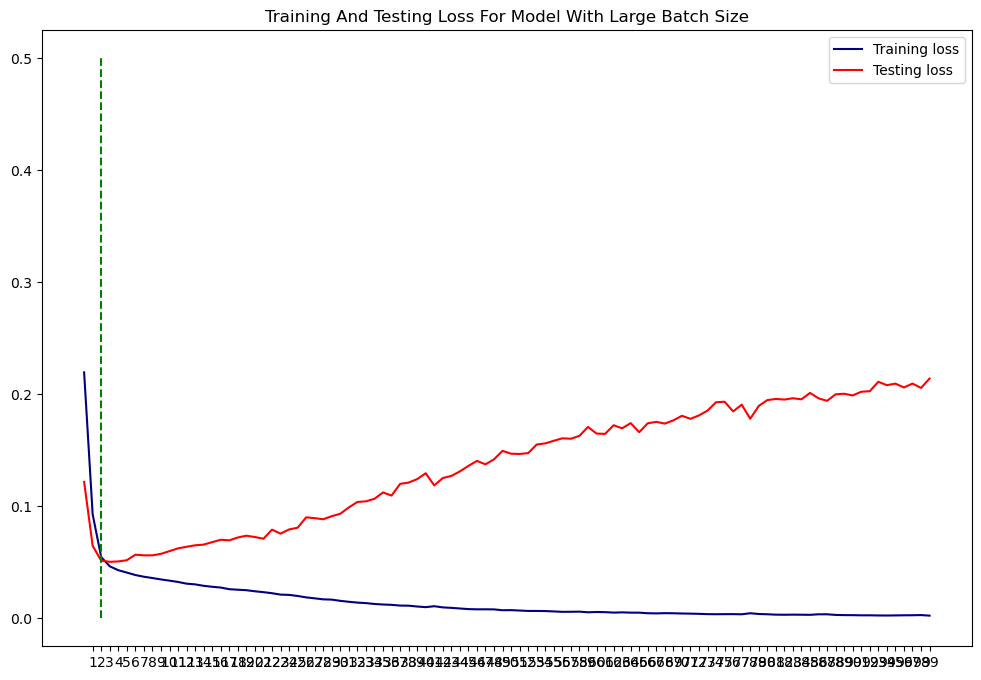

In [ ]:
train_loss = history_dict['loss']
test_loss = history_dict['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.vlines(x=2, ymin=0, ymax=0.5, color='green', linestyle='--')
plt.title('Training and Testing Loss for model with large batch size'.title())
plt.legend()
plt.xticks(range(1, 100, 1))
plt.savefig('../charts/baseline_model_loss.png', bbox_inches='tight')
plt.show()

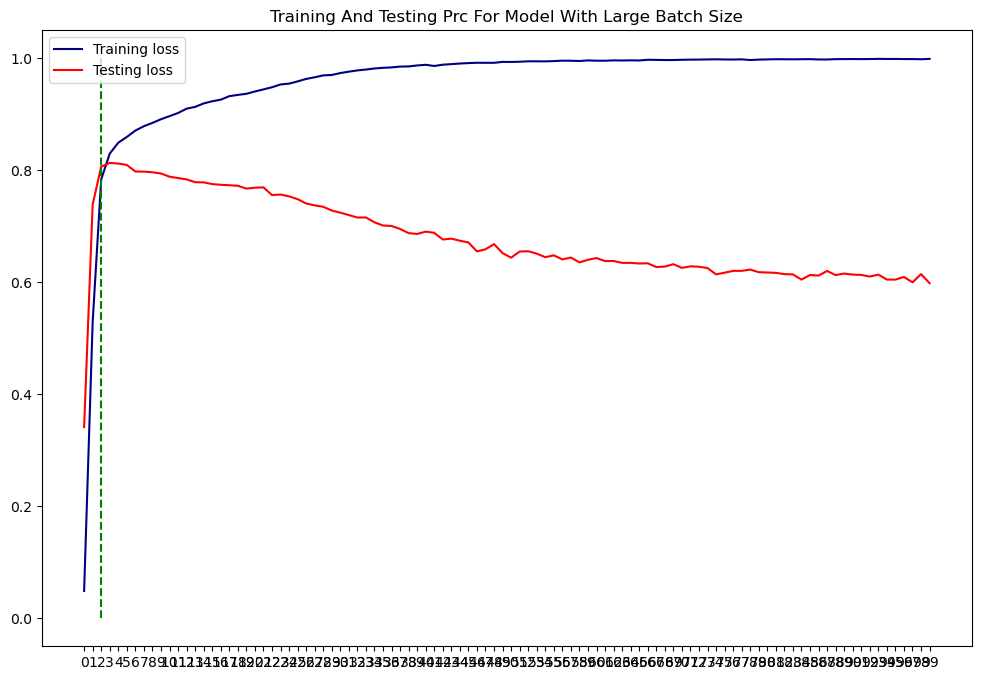

In [ ]:
train_loss = history_dict['prc']
test_loss = history_dict['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.title('Training and Testing prc for model with large batch size'.title())
plt.vlines(x=2, ymin=0, ymax=1.0, color='green', linestyle='--')
plt.legend()
plt.xticks(range(0, 100, 1))
plt.savefig('../charts/baseline_model_prc.png', bbox_inches='tight')
plt.show()

# Model with class weights

In [ ]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
    """
    Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
    Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
    The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
    of appareance of the label when the dataset was processed.
    In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
    Author: Angel Igareta (angel@igareta.com)
    """
    if multi_class:
        # If class is one hot encoded, transform to categorical labels to use compute_class_weight
        if one_hot_encoded:
            class_series = np.argmax(class_series, axis=1)

        # Compute class weights with sklearn method
        class_labels = np.unique(class_series)
        class_weights = compute_class_weight(
            class_weight="balanced", classes=class_labels, y=class_series
        )
        return dict(zip(class_labels, class_weights))
    else:
        # It is neccessary that the multi-label values are one-hot encoded
        mlb = None
        if not one_hot_encoded:
            mlb = MultiLabelBinarizer()
            class_series = mlb.fit_transform(class_series)

        n_samples = len(class_series)
        n_classes = len(class_series[0])

        # Count each class frequency
        class_count = [0] * n_classes
        for classes in class_series:
            for index in range(n_classes):
                if classes[index] != 0:
                    class_count[index] += 1

        # Compute class weights using balanced method
        class_weights = [
            n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count
        ]
        class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
        return dict(zip(class_labels, class_weights))

In [ ]:
class_weights = generate_class_weights(y_train, multi_class=False, one_hot_encoded=True)

In [ ]:
class_weights

{0: 1.7388847375303569,
 1: 16.681451612903224,
 2: 3.1478694622928645,
 3: 55.571641791044776,
 4: 3.3762241566920568,
 5: 18.938453713123092}

In [ ]:
log_dir2 = "logs/fit/model_class_weights" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

In [ ]:
model = nn_creation()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 50)                6050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 6)                

In [ ]:
EPOCHS = 100

history_class_weights = model.fit(
    vectorized_X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(vectorized_X_test, y_test),
    batch_size=1024,
    verbose=1,
    callbacks=[tensorboard_callback],
    class_weight=class_weights,
)

Epoch 1/100
110/110 [==============================] - 7s 64ms/step - loss: 0.0673 - tp: 19129.0000 - fp: 3263.0000 - tn: 642363.0000 - fn: 5439.0000 - accuracy: 0.9870 - precision: 0.8543 - recall: 0.7786 - auc: 0.9926 - prc: 0.8991 - val_loss: 0.0587 - val_tp: 7069.0000 - val_fp: 2111.0000 - val_tn: 274591.0000 - val_fn: 3461.0000 - val_accuracy: 0.9806 - val_precision: 0.7700 - val_recall: 0.6713 - val_auc: 0.9576 - val_prc: 0.7882
Epoch 2/100
110/110 [==============================] - 8s 71ms/step - loss: 0.0632 - tp: 19477.0000 - fp: 3147.0000 - tn: 642479.0000 - fn: 5091.0000 - accuracy: 0.9877 - precision: 0.8609 - recall: 0.7928 - auc: 0.9941 - prc: 0.9081 - val_loss: 0.0589 - val_tp: 7061.0000 - val_fp: 2176.0000 - val_tn: 274526.0000 - val_fn: 3469.0000 - val_accuracy: 0.9803 - val_precision: 0.7644 - val_recall: 0.6706 - val_auc: 0.9597 - val_prc: 0.7871
Epoch 3/100
110/110 [==============================] - 7s 66ms/step - loss: 0.0611 - tp: 19702.0000 - fp: 3044.0000 - tn: 

In [ ]:
model.save('../nn_models/baseline_model_class_weights.h5')

In [ ]:
# %tensorboard --logdir logs/fit/

In [ ]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history_class_weights.history
# Save it under the form of a json file
json.dump(history_dict, open("../nn_models/saved_history_class_weights", 'w'))

In [ ]:
history_class_weights = json.load(open("../nn_models/saved_history_class_weights", 'r'))

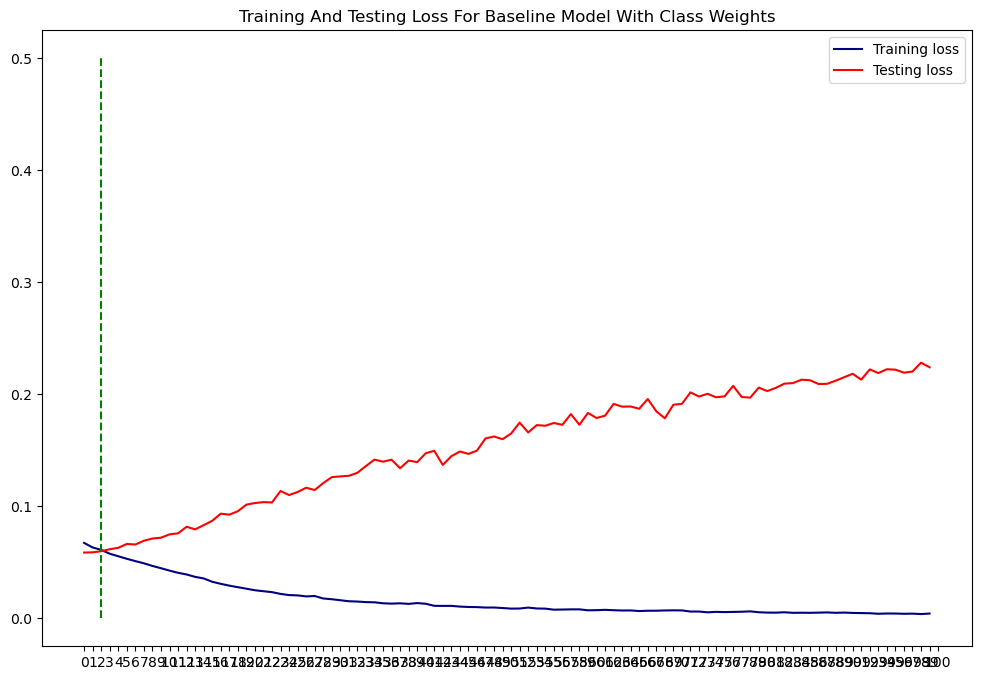

In [ ]:
train_loss = history_class_weights['loss']
test_loss = history_class_weights['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.vlines(x=2, ymin=0, ymax=0.5, color='green', linestyle='--')
plt.title('Training and Testing Loss for Baseline Model with Class Weights'.title())
plt.legend()
plt.xticks(range(0, 101, 1))
plt.savefig('../charts/baseline_model_class_weights_loss.png', bbox_inches='tight')
plt.show()

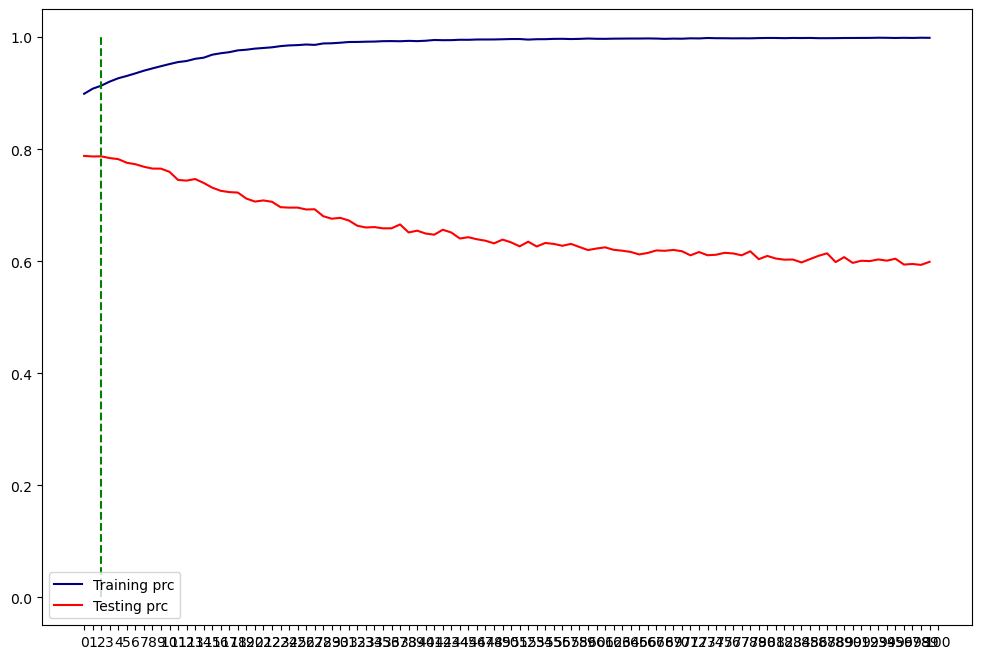

In [ ]:
train_loss = history_class_weights['prc']
test_loss = history_class_weights['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training prc', color='navy')
plt.plot(test_loss, label='Testing prc', color='red')
plt.vlines(x=2, ymin=0, ymax=1.0, color='green', linestyle='--')
plt.legend()
plt.xticks(np.arange(0, 101, 1))
plt.savefig('../charts/baseline_model_class_weights_prc.png', bbox_inches='tight')
plt.show()

In [ ]:
# model = keras.models.load_model("../nn_models/baseline_model.h5")

## Model with epoch 2

This is determined from the convergence in the epoch loss in tensorboard.
The class weights used in the neural network seem to overfit the data, the neural network with the class weights will be used.

In [ ]:
log_dir = "logs/fit/model_stop" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model = nn_creation()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 50)                6050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [ ]:

EPOCHS = 3
history_stop = model.fit(
    vectorized_X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(vectorized_X_test, y_test),
    batch_size=1024,
    verbose=1,
    # class_weight=class_weights,
    callbacks=[tensorboard_callback],
)

Epoch 1/3
109/110 [============================>.] - ETA: 0s - loss: 0.2025 - tp: 104.0000 - fp: 1702.0000 - tn: 643446.0000 - fn: 24444.0000 - accuracy: 0.9610 - precision: 0.0576 - recall: 0.0042 - auc: 0.6723 - prc: 0.0532

2022-10-15 09:23:09.436611: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 11s 73ms/step - loss: 0.2024 - tp: 104.0000 - fp: 1702.0000 - tn: 643924.0000 - fn: 24464.0000 - accuracy: 0.9610 - precision: 0.0576 - recall: 0.0042 - auc: 0.6724 - prc: 0.0532 - val_loss: 0.1209 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 276702.0000 - val_fn: 10530.0000 - val_accuracy: 0.9633 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8664 - val_prc: 0.3997
Epoch 2/3
109/110 [============================>.] - ETA: 0s - loss: 0.0825 - tp: 8238.0000 - fp: 2269.0000 - tn: 642895.0000 - fn: 16294.0000 - accuracy: 0.9723 - precision: 0.7840 - recall: 0.3358 - auc: 0.9434 - prc: 0.5981

2022-10-15 09:23:16.449980: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614430720 exceeds 10% of free system memory.


110/110 [==============================] - 7s 63ms/step - loss: 0.0826 - tp: 8254.0000 - fp: 2271.0000 - tn: 643355.0000 - fn: 16314.0000 - accuracy: 0.9723 - precision: 0.7842 - recall: 0.3360 - auc: 0.9434 - prc: 0.5982 - val_loss: 0.0591 - val_tp: 6389.0000 - val_fp: 1609.0000 - val_tn: 275093.0000 - val_fn: 4141.0000 - val_accuracy: 0.9800 - val_precision: 0.7988 - val_recall: 0.6067 - val_auc: 0.9702 - val_prc: 0.7678
Epoch 3/3
110/110 [==============================] - 7s 64ms/step - loss: 0.0548 - tp: 15029.0000 - fp: 3354.0000 - tn: 642272.0000 - fn: 9539.0000 - accuracy: 0.9808 - precision: 0.8175 - recall: 0.6117 - auc: 0.9777 - prc: 0.7863 - val_loss: 0.0512 - val_tp: 6659.0000 - val_fp: 1463.0000 - val_tn: 275239.0000 - val_fn: 3871.0000 - val_accuracy: 0.9814 - val_precision: 0.8199 - val_recall: 0.6324 - val_auc: 0.9790 - val_prc: 0.8071


In [ ]:
model.save('../nn_models/model_ep2.h5')

In [ ]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history_stop.history
# Save it under the form of a json file
json.dump(history_dict, open("../nn_models/saved_history_ep2", 'w'))

AttributeError: 'dict' object has no attribute 'history'

In [11]:
history_stop = json.load(open("../nn_models/saved_history_ep2", 'r'))

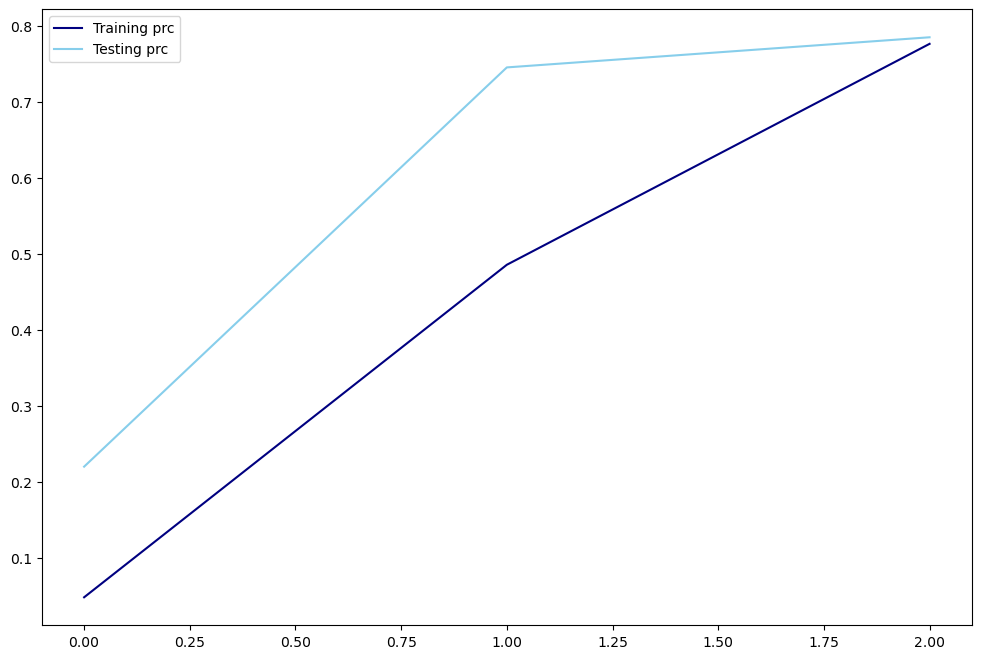

In [12]:
train_loss = history_stop['prc']
test_loss = history_stop['val_prc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training prc', color='navy')
plt.plot(test_loss, label='Testing prc', color='skyblue')
plt.legend();

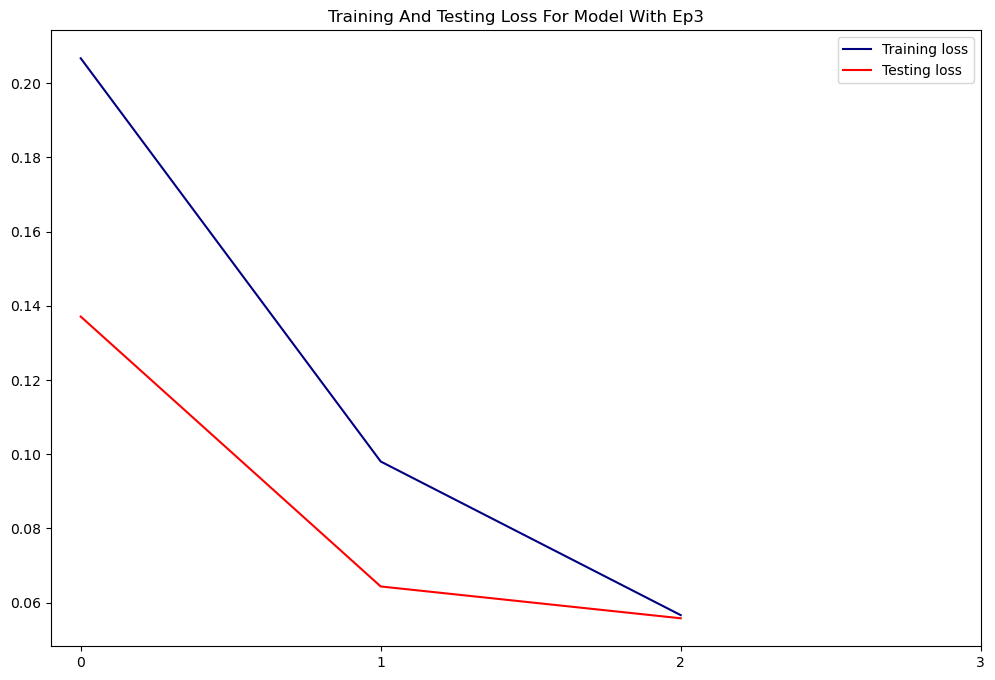

In [ ]:
train_loss = history_stop['loss']
test_loss = history_stop['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='red')
plt.title('Training and Testing Loss for model with ep3'.title())
plt.legend()
plt.xticks(range(0, 4, 1))
plt.savefig('../charts/baseline_model_ep3_loss.png', bbox_inches='tight')
plt.show()

In [ ]:
model = keras.models.load_model("../nn_models/model_ep2.h5")

In [ ]:
# train_predictions_baseline = model.predict(vectorized_X_train, batch_size=1024)
# test_predictions_baseline = model.predict(vectorized_X_test, batch_size=1024)

y_pred = (model.predict(vectorized_X_test, batch_size=1024) > 0.5).astype("int32")

47/47 [==============================] - 1s 17ms/step


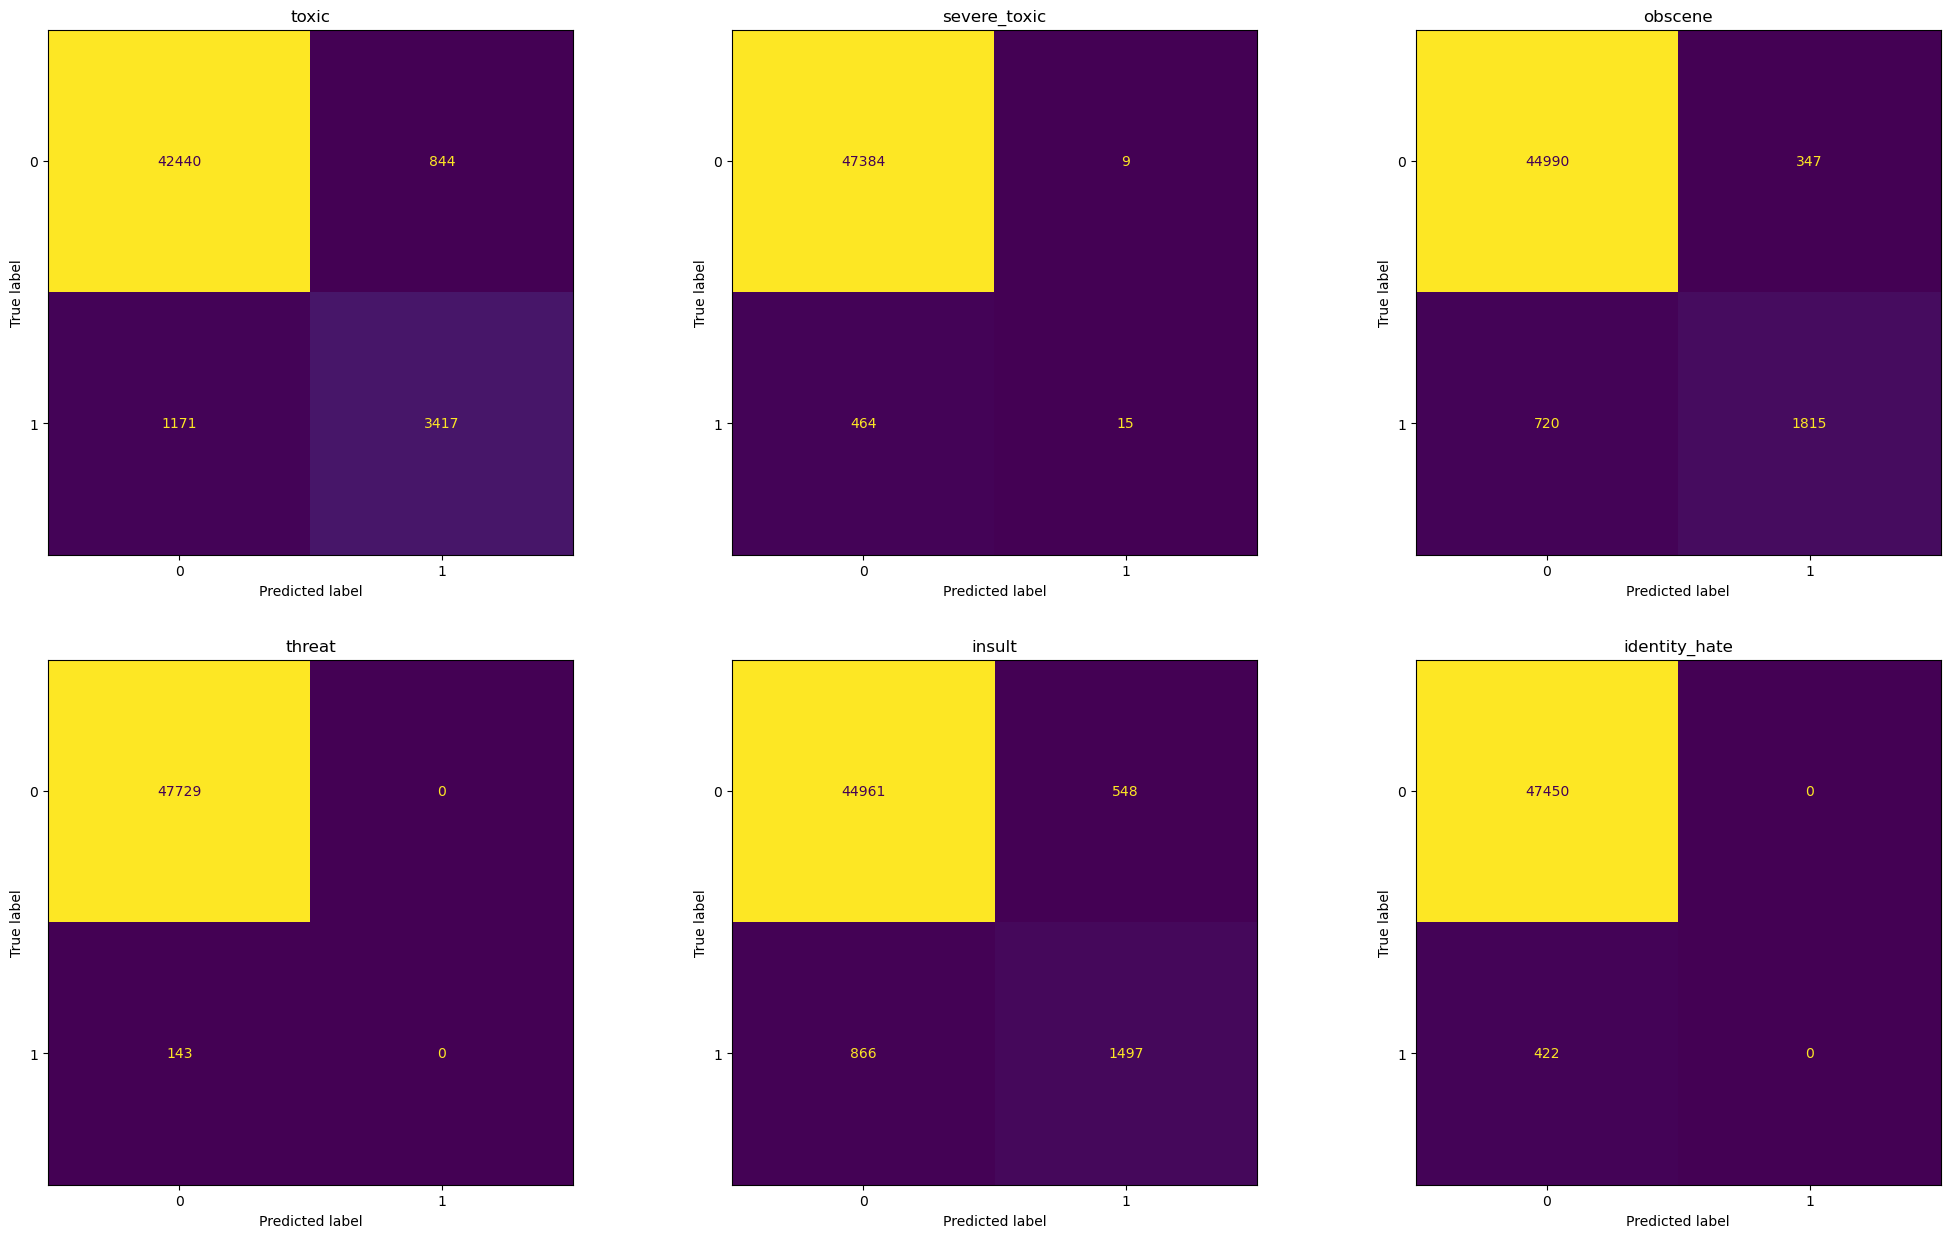

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(6):
    disp = ConfusionMatrixDisplay(
        confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    )
    disp.plot(ax=axes[i], values_format="d",)
    disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    disp.im_.colorbar.remove()

47/47 [==============================] - 1s 17ms/step


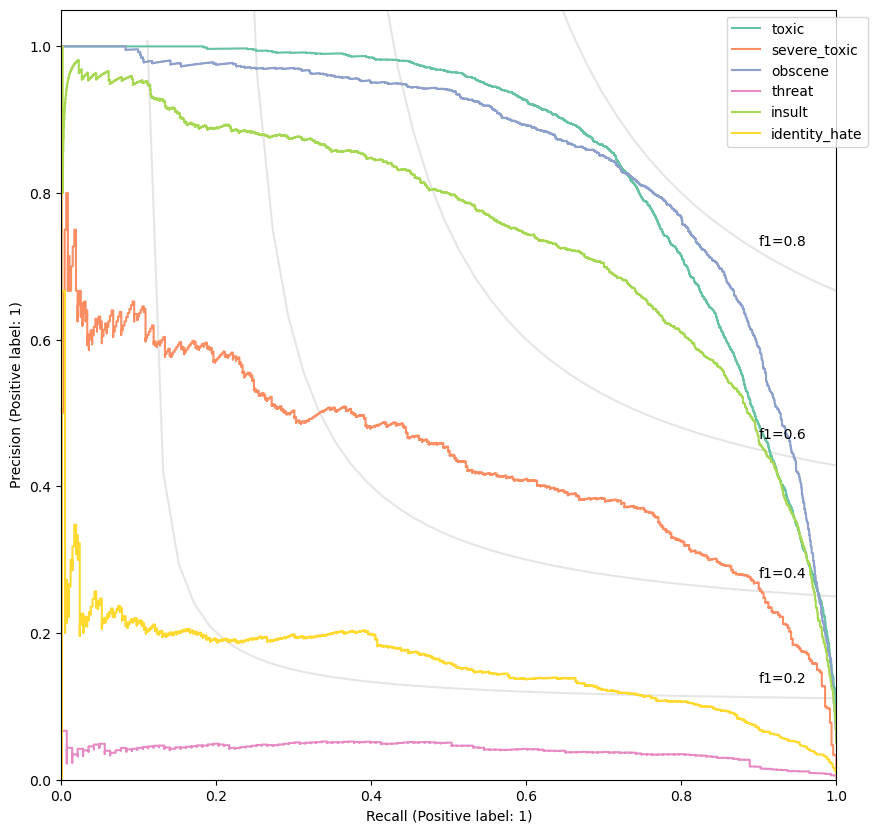

In [ ]:
y_pred = model.predict(vectorized_X_test, batch_size=1024)

f, ax = plt.subplots(figsize=(10, 10))
# axes = axes.ravel()
colors = cycle(sns.color_palette("Set2", 10))
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
#                                                         y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

for i in range(6):
    disp = PrecisionRecallDisplay.from_predictions(
        y_test[:, i], y_pred[:, i], name=features[i])
    plt.close()
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix(y_test[:, i], y_pred[:, i]), display_labels=[0, 1]
    # )
    disp.plot(ax=ax, color=next(colors), label=f"{features[i]}")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best", bbox_to_anchor=(1.05, 1))
    # disp.ax_.set_title(f"{features[i]}")
    # disp.ax_.set_xlabel("")
    # disp.ax_.set_ylabel("")
    # disp.im_.colorbar.remove()

In [ ]:
model.evaluate(vectorized_X_test, y_test)

1496/1496 [==============================] - 12s 7ms/step - loss: 0.0558 - tp: 6744.0000 - fp: 1748.0000 - tn: 274954.0000 - fn: 3786.0000 - accuracy: 0.9807 - precision: 0.7942 - recall: 0.6405 - auc: 0.9726 - prc: 0.7851


[0.05577217787504196,
 6744.0,
 1748.0,
 274954.0,
 3786.0,
 0.980733335018158,
 0.7941592335700989,
 0.6404558420181274,
 0.9725923538208008,
 0.7850903868675232]

# Model Comparsion

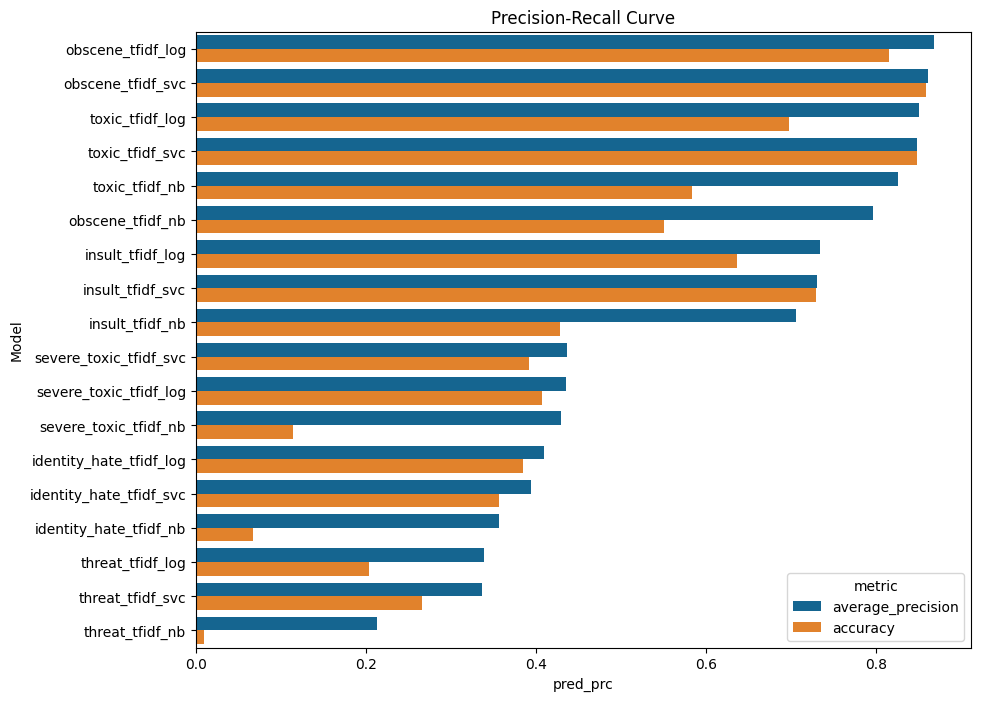

In [262]:
# Plot of prc values for all models and features
plt.figure(figsize=(10,8))

sns.barplot(y='index', x='pred_prc', hue='metric', data=final_results.sort_values(by='pred_prc', ascending=False))

plt.ylabel('Model')
plt.title('Precision-Recall Curve')
plt.savefig('../charts/model_plots/overall_prc.png', bbox_inches='tight')
plt.show()

In [53]:
# final_results.query("index.str.contains('svc')", engine='python')
toxic_models = [
    "toxic_tfidf_log", 
    "toxic_tfidf_nb", 
    "toxic_tfidf_svc"
    ]
severe_toxic_models = [
    "severe_toxic_tfidf_log",
    "severe_toxic_tfidf_nb",
    "severe_toxic_tfidf_svc",
    ]
obscene_models = [
    "obscene_tfidf_log", 
    "obscene_tfidf_nb", 
    "obscene_tfidf_svc"
    ]
threat_models = [
    "threat_tfidf_log", 
    "threat_tfidf_nb", 
    "threat_tfidf_svc"
    ]
insult_models = [
    "insult_tfidf_log", 
    "insult_tfidf_nb", 
    "insult_tfidf_svc"
    ]
identity_hate_models = [
    "identity_hate_tfidf_log",
    "identity_hate_tfidf_nb",
    "identity_hate_tfidf_svc",
    ]

all_models_list = [
    toxic_models,
    severe_toxic_models,
    obscene_models,
    threat_models,
    insult_models,
    identity_hate_models
]    

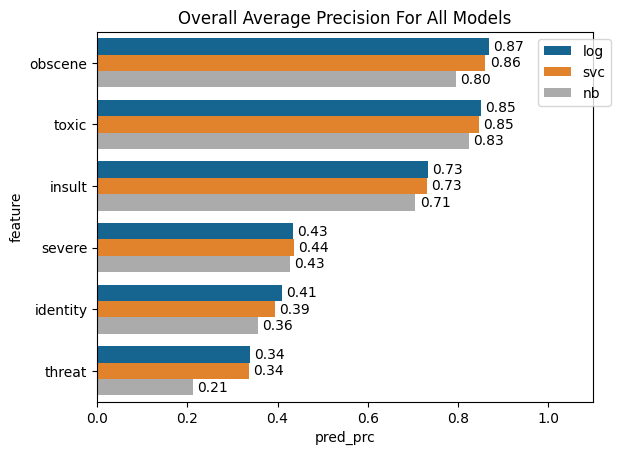

In [270]:
# Creation of temp df with the models with the average_precision metrics and prc values only
temp_df = final_results[(final_results['metric'] == 'average_precision')][['index', 'pred_prc']].reset_index(drop=True).copy()

temp_df['model_type'] = temp_df['index'].apply(lambda x: x.split('_')[-1])
temp_df['feature'] = temp_df['index'].apply(lambda x: x.split('_')[0])

temp_df = temp_df.drop('index', axis=1).sort_values(by='pred_prc', ascending=False)

ax = sns.barplot(
    data= temp_df,
    x='pred_prc',
    y='feature',
    hue='model_type',
    # color='blue'
)

plt.bar_label(ax.containers[0], fmt='%.2f', padding=3)
plt.bar_label(ax.containers[1], fmt='%.2f', padding=3)
plt.bar_label(ax.containers[2], fmt='%.2f', padding=3)

plt.xlim(0, 1.1)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.title("Overall Average Precision for all models".title())

plt.savefig('../charts/model_plots/overall_prc_specific.png', bbox_inches='tight')
plt.show()

In [268]:
# fig, axes = plt.subplots(3, 2, figsize=(15, 10))


# for count, model in enumerate(zip(all_models_list, axes.flat)):
#     sns.barplot(
#         y="model_type",
#         x="pred_prc",
#         data=temp_df,
#         ax=model[1],
#         color=color_pal[count]
#     )
#     model[1].set_title(model[0][0].split("_")[0].title())
#     model[1].set_ylabel("")
#     model[1].set_xlabel("")
#     model[1].bar_label(model[1].containers[0], fmt="%.2f", padding=3)
#     # model[1].bar_label(model[1].containers[1], fmt='%.2f', padding=3)
#     model[1].set_xlim(0,1)
#     handles, labels = model[1].get_legend_handles_labels()
#     # model[1].get_legend().remove()

# plt.tight_layout()
# # handles, labels = axes.get_legend_handles_labels()
# fig.legend(handles, labels, bbox_to_anchor=(1.0, 1.05), loc="upper right")
# # fig.legend(loc='upper right')

In [269]:
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))


# for model in zip(all_models_list, axes.flat):
#     plt.figure(figsize=(10, 8))
#     sns.barplot(
#         data=final_results[final_results['index'].isin(model)],
#         y="index",
#         x="pred_prc",
#         hue="metric",
#         ax=model[1],
#     )
#     plt.show()